# Get links for visualization

In [2]:
import pandas as pd
from scipy.spatial import ConvexHull
from tqdm import tqdm
import socket
import torch
hostname = socket.gethostname()
if hostname=='carbon':
    path = 'C:/Users/heyouwei/code/car/20230415/'
else:
    path = 'C:/Users/heyou/Documents/coding/20230415/'
key_products_df = pd.read_csv(path+'key_products.csv',low_memory=False).sort_values(by=['year'],ascending=False)
genolist_df = pd.read_csv(path+'mixed_genolist.csv',low_memory=False)

In [327]:
beginyear = 2013
endyear = 2024
year_norm = False
if year_norm == True:
    input_temp_title = str(beginyear)+'_'+str(endyear)+'_yearly'
else:
    input_temp_title = str(beginyear)+'_'+str(endyear)+'_period'
filepath = path+input_temp_title+'/'
tensorfname = filepath + 'cos_weighttyp_tensor.pt'
node_df = key_products_df[(key_products_df.year>=beginyear)&(key_products_df.year<=endyear)]
yearlst = node_df.year.tolist() 
adj_x = torch.load(tensorfname)

In [328]:
def getproduct(idx,node_df):
    productname = node_df.loc[idx,'productname']
    year = node_df.loc[idx,'year']
    series = node_df.loc[idx,'series']
    brand = node_df.loc[idx,'brand']
    return productname,year,series,brand

def getlinks(productname,node_df,adj_x,anc_count=5):#find 5 maximum ancestors for each node and the ancestor have to be earlier than the focal node but no year difference limitation
    link_df = pd.DataFrame()
    node_year =  node_df[node_df.productname==productname].year.astype('int').tolist()[0] 
    nodeid = node_df[node_df.productname==productname].index.astype('int').tolist()[0]#
    ancnodeid_lst = node_df[(node_df.year.astype('int')<node_year)].index.astype('int').tolist()#
    if len(ancnodeid_lst) != 0:
        a = adj_x[nodeid][ancnodeid_lst]#多个anc与一个foc的相似性矩阵,
        sim_lst, anc_idx_lst = torch.topk(a, anc_count, dim=0)
        foc_productname,foc_year,foc_series,foc_brand = getproduct(nodeid,node_df)
        dic = {'foc_id':nodeid,'foc_productname':foc_productname,'foc_year':foc_year,'foc_series':foc_series,'foc_brand':foc_brand}
        for idx in range(anc_count):
            dic['anc_count'] = idx+1
            dic['anc_idx'] = int(anc_idx_lst[idx])
            dic['anc_id'] = ancnodeid_lst[anc_idx_lst[idx]]
            anc_productname,anc_year,anc_series,anc_brand = getproduct(dic['anc_id'],node_df)
            dic['anc_productname'] = anc_productname
            dic['anc_year'] = anc_year
            dic['anc_brand'] = anc_brand
            dic['anc_series'] = anc_series
            dic['sim'] = float(sim_lst[idx])
            dic['year_diff'] = foc_year - anc_year
            if anc_brand == foc_brand:
                dic['brand_diff'] = 1
            else:
                dic['brand_diff'] = 0
            link_df = pd.concat([link_df,pd.DataFrame([dic])])
        link_df = link_df.reset_index(drop=True)
    return link_df    
anc_count = 5
link_df = pd.DataFrame()
for productname in tqdm(node_df['productname'].tolist()):
    link_df = pd.concat([link_df,getlinks(productname,node_df,adj_x,anc_count=anc_count)])
link_df = link_df.reset_index(drop=True) 
link_df.to_csv(filepath+'anc_'+str(anc_count)+'link_df.csv')
print('Save to:',filepath+'anc_'+str(anc_count)+'link_df.csv')
link_df

100%|██████████| 4496/4496 [02:02<00:00, 36.84it/s] 


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/anc_5link_df.csv


,foc_id,foc_productname,foc_year,foc_series,foc_brand,anc_count,anc_idx,anc_id,anc_productname,anc_year,anc_brand,anc_series,sim,year_diff,brand_diff
0,0,2024 Lotus Emira,2024,emira,lotus,1,1026,1200,2021 Mercedes-Benz GLC 300,2021,mercedes benz,glc 300,0.622188,3,0
1,0,2024 Lotus Emira,2024,emira,lotus,2,2584,2892,2017 Audi A7,2017,audi,a7,0.600109,7,0
2,0,2024 Lotus Emira,2024,emira,lotus,3,2447,2343,2018 Nissan NV200,2018,nissan,nv200,0.593471,6,0
3,0,2024 Lotus Emira,2024,emira,lotus,4,3751,4035,2014 Chevrolet Express 3500,2014,chevrolet,express 3500,0.507807,10,0
4,0,2024 Lotus Emira,2024,emira,lotus,5,3511,3739,2015 Land Rover LR2,2015,land rover,lr2,0.460827,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20760,3901,2014 Honda Ridgeline,2014,ridgeline,honda,1,13,4374,2013 GMC Yukon XL,2013,gmc,yukon xl,0.346686,1,0
20761,3901,2014 Honda Ridgeline,2014,ridgeline,honda,2,194,4237,2013 GMC Savana 3500,2013,gmc,savana 3500,0.274204,1,0
20762,3901,2014 Honda Ridgeline,2014,ridgeline,honda,3,269,4291,2013 Chevrolet Traverse,2013,chevrolet,traverse,0.112066,1,0
20763,3901,2014 Honda Ridgeline,2014,ridgeline,honda,4,3,4384,2013 Volkswagen Jetta,2013,volkswagen,jetta,0.106922,1,0


In [329]:
link_df[(link_df['foc_id']==20)]

,foc_id,foc_productname,foc_year,foc_series,foc_brand,anc_count,anc_idx,anc_id,anc_productname,anc_year,anc_brand,anc_series,sim,year_diff,brand_diff
5,20,2024 BMW X5,2024,x5,bmw,1,386,148,2023 Genesis GV70,2023,genesis,gv70,0.481834,1,0
6,20,2024 BMW X5,2024,x5,bmw,2,807,580,2022 BMW M4,2022,bmw,m4,0.481834,2,1
7,20,2024 BMW X5,2024,x5,bmw,3,1145,925,2021 Bentley Bentayga Hybrid,2021,bentley,bentayga hybrid,0.481834,3,0
8,20,2024 BMW X5,2024,x5,bmw,4,1415,1712,2020 Mercedes-Benz Sprinter 4500,2020,mercedes benz,sprinter 4500,0.434153,4,0
9,20,2024 BMW X5,2024,x5,bmw,5,766,621,2022 Ferrari SF90 Stradale,2022,ferrari,sf90 stradale,0.431787,2,0


In [331]:
link_df.sim.mean()

0.6934046798130132

In [330]:
import pandas as pd
from tqdm import tqdm

def getcddf(link_df, anc_count_lst, year_diff_lst=[1, 2, 3, 4, 5], sim_threshold=0):#ancestor don't have year difference limitation. only descendants have year difference limitation.
    cd_df = pd.DataFrame()

    for foc_id in tqdm(link_df['foc_id'].unique()):
        df = link_df[link_df['foc_id'] == foc_id].copy().reset_index(drop=True)
        productname, foc_year, series, brand = df.loc[0, ['foc_productname', 'foc_year', 'foc_series', 'foc_brand']]

        for year_diff in year_diff_lst:
            for anc_count in anc_count_lst:
                anc_set = set(link_df[(link_df['foc_id'] == foc_id) & 
                                      (link_df['anc_count'] <= anc_count) & 
                                      (link_df['sim'] >= sim_threshold)]['anc_id'])
                
                des_set = set(link_df[(link_df['anc_id'] == foc_id) & 
                                      (link_df['year_diff'] <= year_diff) & 
                                      (link_df['anc_count'] <= anc_count) & 
                                      (link_df['sim'] >= sim_threshold)]['foc_id'])
                
                ancdes_set = set(link_df[(link_df['anc_id'].isin(anc_set)) & 
                                         (link_df['foc_year'] > foc_year) & 
                                         (link_df['anc_count'] <= anc_count) & 
                                         (link_df['sim'] >= sim_threshold)]['foc_id'])
                
                ni = len(des_set - ancdes_set)
                nj = len(des_set & ancdes_set)
                nk = len(ancdes_set - des_set)

                if ni + nj + nk != 0:
                    d_index = (ni - nj) / (ni + nj + nk)
                    dic = {
                        'foc_id': foc_id,
                        'productname': productname,
                        'brand': brand,
                        'series': series,
                        'd_index': d_index,
                        'foc_year': foc_year,
                        'ni': ni,
                        'nj': nj,
                        'nk': nk,
                        'anc_count': len(anc_set),
                        'des_count': len(des_set),
                        'ancdes_count': len(ancdes_set),
                        'anc_link_count': anc_count,
                        'year_diff': year_diff,
                        'sim_threshold': sim_threshold
                    }
                    cd_df = pd.concat([cd_df, pd.DataFrame([dic])], ignore_index=True)

    return cd_df


In [332]:
#sim_threshold = 0.5
for sim_threshold in [0.5,0.6,0.7,0.8,0.9]:
    cd_df = getcddf(link_df,[1,2,3,4,5], year_diff_lst=[1, 2, 3, 4, 5], sim_threshold=sim_threshold)
    cd_df.to_csv(filepath+'sim_'+str(sim_threshold)+'_anc_'+str(5)+'_cd_df.csv',index=False)
    print('Save to:',filepath+'sim_'+str(sim_threshold)+'_anc_'+str(5)+'_cd_df.csv')


100%|██████████| 4153/4153 [18:39<00:00,  3.71it/s]


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/sim_0.5_anc_5_cd_df.csv


100%|██████████| 4153/4153 [18:33<00:00,  3.73it/s]


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/sim_0.6_anc_5_cd_df.csv


100%|██████████| 4153/4153 [18:02<00:00,  3.84it/s]


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/sim_0.7_anc_5_cd_df.csv


100%|██████████| 4153/4153 [17:19<00:00,  4.00it/s]


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/sim_0.8_anc_5_cd_df.csv


100%|██████████| 4153/4153 [14:40<00:00,  4.72it/s]


Save to: C:/Users/heyouwei/code/car/20230415/2013_2024_period/sim_0.9_anc_5_cd_df.csv


In [ ]:
from scipy.stats import pearsonr

results_df = pd.DataFrame()
for sim_threshold in tqdm([0.5,0.6,0.7,0.8,0.9]):
    cd_df = pd.read_csv(filepath+'sim_'+str(sim_threshold)+'_anc_'+str(5)+'_cd_df.csv')
    for n in range(5):
        for m in range(5):
            if cd_df[(cd_df['anc_link_count']<=n+1)&(cd_df['year_diff']<=m+1)]['d_index'].mean()>0:      
                yearly_avg = cd_df[(cd_df['anc_link_count']<=n+1)&(cd_df['year_diff']<=m+1)].groupby('foc_year')['d_index'].mean().reset_index() # 计算 year 与年平均 d_index 之间的相关系数 
                correlation, p_value = pearsonr(yearly_avg['foc_year'], yearly_avg['d_index'])
                if (correlation<0 ) and (p_value<0.05):
                    avg_d = cd_df[(cd_df['anc_link_count']<=n+1)&(cd_df['year_diff']<=m+1)]['d_index'].mean()
                    avg_sim = link_df[(link_df['anc_count']<=n+1)&(link_df['year_diff']<=m+1)]['sim'].mean()
                    anc_link_count = n+1
                    year_diff = m+1
                    dic = {'avg_d':avg_d,
                        'avg_sim':avg_sim,
                        'anc_link_count':anc_link_count,
                        'year_diff':year_diff,
                        'correlation':correlation,
                        'p_value':p_value,
                        'sim_threshold':sim_threshold
                        }
                    results_df = pd.concat([results_df,pd.DataFrame([dic])])
results_df = results_df.reset_index(drop=True) 


100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


,avg_d,avg_sim,anc_link_count,year_diff,correlation,p_value,sim_threshold
0,0.339381,0.774813,2,1,-0.636373,0.047908,0.5
1,0.419899,0.789992,2,2,-0.702670,0.023440,0.5
2,0.450053,0.787881,2,3,-0.723509,0.018024,0.5
3,0.465728,0.787088,2,4,-0.733780,0.015704,0.5
4,0.475184,0.786769,2,5,-0.739505,0.014506,0.5
...,...,...,...,...,...,...,...
74,0.121592,0.657530,5,1,-0.720834,0.018665,0.8
75,0.130848,0.686274,5,2,-0.721690,0.018458,0.8
76,0.137846,0.692824,5,3,-0.724578,0.017772,0.8
77,0.142234,0.693960,5,4,-0.727356,0.017129,0.8


In [336]:
cd_df.columns

Index(['foc_id', 'productname', 'brand', 'series', 'd_index', 'foc_year', 'ni',
       'nj', 'nk', 'anc_count', 'des_count', 'ancdes_count', 'anc_link_count',
       'year_diff', 'sim_threshold'],
      dtype='object')

In [355]:
#total_cd_df[(total_cd_df['brand']=='tesla')&(total_cd_df['ancdes_count']>1)&(total_cd_df['year_diff']<=5)&(total_cd_df['d_index']>0)]

In [ ]:
#sim_threshold = 0.5
anc_count = 5
total_cd_df = pd.DataFrame()
for sim_threshold in [0.5,0.6,0.7,0.8,0.9]:
    total_cd_df = pd.concat([total_cd_df,pd.read_csv(filepath+'sim_'+str(sim_threshold)+'_anc_'+str(anc_count)+'_cd_df.csv')])
total_cd_df = total_cd_df.reset_index()
total_cd_df.to_csv(filepath+'sim_total_anc_'+str(anc_count)+'_cd_df.csv',index=False)
#cd_df[(cd_df['brand']=='tesla')&(cd_df['d_index']>0)]#['foc_year'].min()

In [484]:
total_cd_df.columns

Index(['index', 'foc_id', 'productname', 'brand', 'series', 'd_index',
       'foc_year', 'ni', 'nj', 'nk', 'anc_count', 'des_count', 'ancdes_count',
       'anc_link_count', 'year_diff', 'sim_threshold'],
      dtype='object')

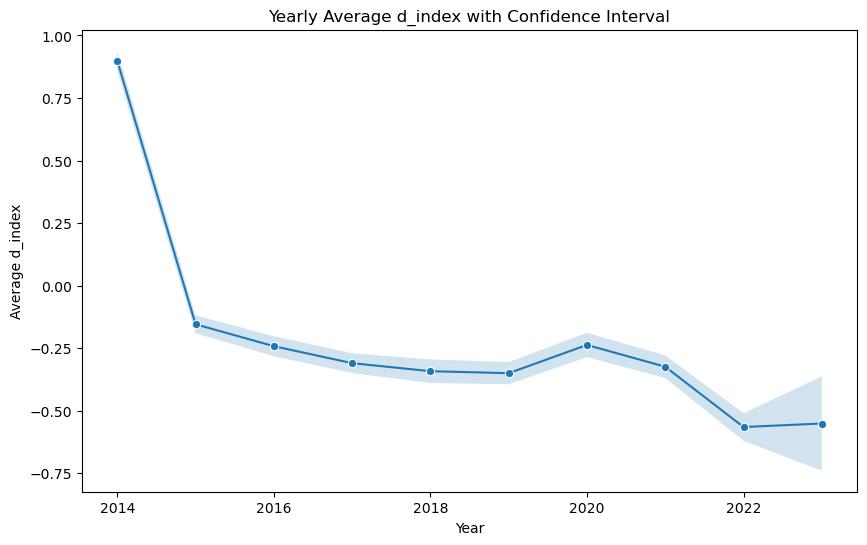

In [491]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
total_cd_df = pd.read_csv(filepath+'sim_total_anc_'+str(anc_count)+'_cd_df.csv')

# 假设 cd_df 是你的数据集
# 计算每年的平均 d_index 和标准误
trend_df = pd.merge(total_cd_df,node_df[['productname','cartype']].copy(),on='productname',how='inner')
trend_df = trend_df[(trend_df['anc_link_count']==3)&(trend_df['year_diff']<=1)&(trend_df['sim_threshold']==0.5)].copy()

yearly_stats = trend_df.groupby('foc_year')['d_index'].agg(['mean', 'sem']).reset_index()

# 计算置信区间（95%）
yearly_stats['ci_lower'] = yearly_stats['mean'] - 1.96 * yearly_stats['sem']
yearly_stats['ci_upper'] = yearly_stats['mean'] + 1.96 * yearly_stats['sem']

# 绘制趋势图
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_stats, x='foc_year', y='mean', marker='o')
plt.fill_between(yearly_stats['foc_year'], yearly_stats['ci_lower'], yearly_stats['ci_upper'], alpha=0.2)
plt.title('Yearly Average d_index with Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Average d_index')
plt.show()


In [174]:
trend_df.columns

Index(['foc_id', 'productname', 'brand', 'series', 'd_index', 'foc_year', 'ni',
       'nj', 'nk', 'anc_count', 'des_count', 'ancdes_count', 'anc_link_count',
       'year_diff', 'sim_threshold'],
      dtype='object')

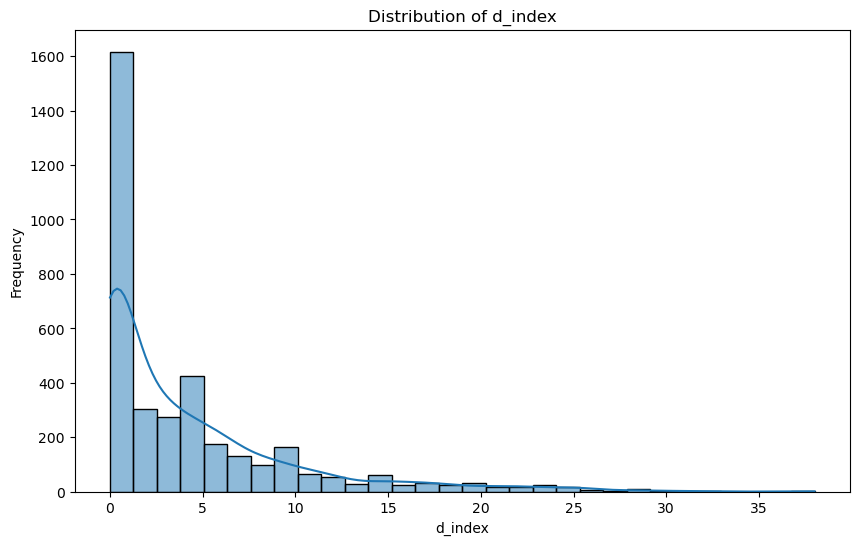

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 cd_df 是你的数据集
# 绘制 d_index 的分布图
plt.figure(figsize=(10, 6))
sns.histplot(trend_df['nk'], kde=True, bins=30)
plt.title('Distribution of d_index')
plt.xlabel('d_index')
plt.ylabel('Frequency')
plt.show()


In [405]:
productname = '2014 Tesla Model S'
#cd_df[(cd_df['brand']=='tesla')&(cd_df['year_diff']>=1)&(cd_df['anc_link_count']>=2)&(cd_df['d_index']>=0.3)]

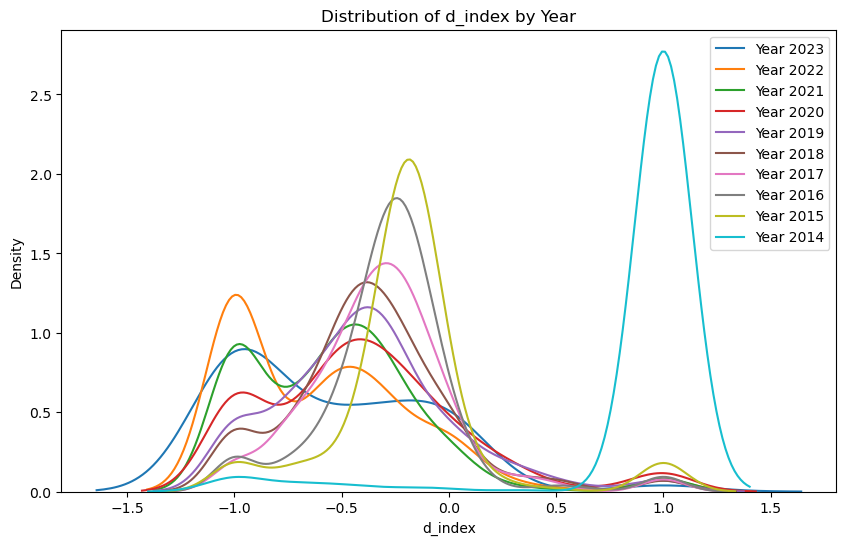

2023 vs 2022 - KS Statistic: 0.09081715210355987, p-value: 0.8361192956280181
2022 vs 2021 - KS Statistic: 0.1444758510507558, p-value: 0.0003786472525860626
2021 vs 2020 - KS Statistic: 0.15172062845874945, p-value: 0.00018435342979171104
2020 vs 2019 - KS Statistic: 0.0857419931738895, p-value: 0.1007331146163223
2019 vs 2018 - KS Statistic: 0.08133916522074416, p-value: 0.12536306538990244
2018 vs 2017 - KS Statistic: 0.0964143615005684, p-value: 0.040006616530801
2017 vs 2016 - KS Statistic: 0.13833214254377718, p-value: 0.0008303567990837015
2016 vs 2015 - KS Statistic: 0.2109939819863484, p-value: 5.245536290053604e-08
2015 vs 2014 - KS Statistic: 0.8811640211640211, p-value: 3.37555476772982e-148


In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# 假设 cd_df 是你的数据集
# 绘制不同年份的 d_index 分布图
col_name = 'd_index'
plt.figure(figsize=(10, 6))
for year in trend_df['foc_year'].unique():
    sns.kdeplot(trend_df[trend_df['foc_year'] == year][col_name], label=f'Year {year}')
plt.title('Distribution of '+col_name+' by Year')
plt.xlabel(col_name)
plt.ylabel('Density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov 检验
years = trend_df['foc_year'].unique()
ks_results = {}
for i in range(len(years) - 1):
    ks_stat, p_value = ks_2samp(trend_df[trend_df['foc_year'] == years[i]][col_name],
                                trend_df[trend_df['foc_year'] == years[i + 1]][col_name])
    ks_results[f'{years[i]} vs {years[i + 1]}'] = (ks_stat, p_value)

# 输出 Kolmogorov-Smirnov 检验结果
for comparison, (ks_stat, p_value) in ks_results.items():
    print(f'{comparison} - KS Statistic: {ks_stat}, p-value: {p_value}')


In [201]:
from sklearn import preprocessing 
def chrstrtolist(chstr):#通过字符串转换成list
    chrlist = str(chstr).split("|")
    if chrlist[-1] == '':
        chrlist.pop()
    chrlist.sort()
    return chrlist

def getdatabyyear(key_products_df,beginyear,endyear):
    df = key_products_df[(key_products_df.year>=beginyear) & (key_products_df.year<=endyear)]
    return df

def getidx_df(products_df):
    idx_df = products_df.loc[:,['productname','year']]
    idx_df['originalidx'] = idx_df.index.tolist()
    idx_df['new_id'] = list(range(len(idx_df)))
    return idx_df

def dfstrtochrom(df):#返回df形式的features：x，labels：y
    x_con = pd.DataFrame()
    x_dis = pd.DataFrame()
    y = pd.DataFrame()
    y['price'] = df.price
    name_df = df['productname']
    #print('Get features!')
    for i in tqdm(df.index.tolist()):
        chro = df.loc[i,'chro']
        con_chro = df.loc[i,'con_chro']
        conchro_lst =  chrstrtolist(con_chro)
        productgenolst  = chrstrtolist(chro)
        dic = {}
        for g in productgenolst:
            if g[0] == 'd':#二进制的genotype
                dic[g] = 1
        #x_dis = x_dis.append(dic,ignore_index=True)
        x_dis = pd.concat([x_dis,pd.DataFrame([dic])])
        dic = {}
        for cgeno in conchro_lst: #continues 的genotype
            cgeno_idx = cgeno.split(':')[0] 
            cgeno_value = float(cgeno.split(':')[1].split(',')[0])
            dic[cgeno_idx] = cgeno_value
        #x_con = x_con.append(dic,ignore_index=True)
        x_con = pd.concat([x_con,pd.DataFrame([dic])])
    x = pd.concat([x_con,x_dis],axis=1)
    x = x.fillna(value=0)
    x.index = df.index
    y.index = df.index
    name_df.index = df.index
    return x,y,name_df

def dfstrtochromnorm(df,filepath,input_temp_title):#返回经过normalization的df形式的features：x（normalization），labels：y （normalization）
    #只normalize连续变量，和价格，不normalize类型变量
    norm = 'l1'
    x_con = pd.DataFrame()
    x_dis = pd.DataFrame()
    y = pd.DataFrame()
    y['price'] = df.price
    name_df = df['productname']
    #print('Get features!')
    if (not os.path.exists(filepath+input_temp_title+'_x_con.csv')) or (not os.path.exists(filepath+input_temp_title+'_x_dis.csv')) or (not os.path.exists(filepath+input_temp_title+'_price.csv')):
        print('开始整理基因！')
        for i in tqdm(df.index.tolist(), position=0, leave=True):
            chro = df.loc[i,'chro']
            con_chro = df.loc[i,'con_chro']
            conchro_lst =  chrstrtolist(con_chro)
            productgenolst  = chrstrtolist(chro)
            dic = {}
            for g in productgenolst:
                if g[0] == 'd':#二进制的genotype
                    dic[g] = 1
            #x_dis = x_dis.append(dic,ignore_index=True)
            x_dis = pd.concat([x_dis,pd.DataFrame([dic])])
            dic = {}
            for cgeno in conchro_lst: #continues 的genotype
                cgeno_idx = cgeno.split(':')[0] 
                cgeno_value = float(cgeno.split(':')[1].split(',')[0])
                dic[cgeno_idx] = cgeno_value
            #x_con = x_con.append(dic,ignore_index=True)
            x_con = pd.concat([x_con,pd.DataFrame([dic])])
        print('保存原始基因信息！')
        x_con.to_csv(filepath+input_temp_title+'_x_con.csv',index=False)
        x_dis.to_csv(filepath+input_temp_title+'_x_dis.csv',index=False)
        y.to_csv(filepath+input_temp_title+'_price.csv',index=False)
    else:
        print('读取基因信息！')
        x_con = pd.read_csv(filepath+input_temp_title+'_x_con.csv')
        x_dis = pd.read_csv(filepath+input_temp_title+'_x_dis.csv')
        y = pd.read_csv(filepath+input_temp_title+'_price.csv')
    x_con = x_con.fillna(value=0)
    x_dis = x_dis.fillna(value=0)
    y = y.fillna(value=0)
    print('Normalize continuous x!')
    # 对每列进行L1归一化
    x_con.reset_index(drop=True, inplace=True)
    x_dis.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    norm_x_con = pd.DataFrame(preprocessing.normalize(x_con,norm=norm,axis=0),columns=x_con.columns)
    #norm_x_con = x_con.apply(lambda x: x / x.abs().sum(), axis=0)
    #norm_x_con = normalizetensor(x_con)
    norm_x = pd.concat([norm_x_con,x_dis],axis=1)
    norm_x.index = df.index
    y.index = df.index
    name_df.index = df.index
    print('Normalize y!')
    norm_y = pd.DataFrame(preprocessing.normalize(y,norm=norm,axis=0),columns=y.columns)
    #norm_y = y.apply(lambda x: x / x.abs().sum(), axis=0)
    #norm_y = normalizetensor(y)
    return norm_x,norm_y,name_df

def getdatasets(key_products_df,beginyear,endyear,filepath,input_temp_title):#生成数据集
    from sklearn.preprocessing import StandardScaler
    df = getdatabyyear(key_products_df,beginyear,endyear)  
    if (not os.path.exists(filepath+input_temp_title+'_normx.csv')) or (not os.path.exists(filepath+input_temp_title+'_normy.csv')) or (not os.path.exists(filepath+input_temp_title+'_name.csv')):
        print('Generate norm_x and norm_y!')
        norm_x,norm_y,name_df = dfstrtochromnorm(df,filepath,input_temp_title)
        #print('Standardize x and y!')
        #scaler = StandardScaler()
        #norm_x = scaler.fit_transform(x)
        #norm_y = scaler.fit_transform(y)
        print('Save dfs to files!')
        norm_y.to_csv(filepath+input_temp_title+'_normy.csv',index=False)
        print('Saving y finished!')
        norm_x.to_csv(filepath+input_temp_title+'_normx.csv',index=False)
        print('Saving x finished!')
        name_df.to_csv(filepath+input_temp_title+'_name.csv',index=True)
        print('Saving namedf finished!')
    else:
        print('Start loading norm_x and norm_y!')
        print('Load '+filepath+input_temp_title+'_normx.csv')
        norm_x = pd.read_csv(filepath+input_temp_title+'_normx.csv',low_memory=False)
        print('Load '+filepath+input_temp_title+'_normy.csv')
        norm_y = pd.read_csv(filepath+input_temp_title+'_normy.csv',low_memory=False)
        print('Load '+filepath+input_temp_title+'_name.csv')
        name_df = pd.read_csv(filepath+input_temp_title+'_name.csv',low_memory=False)
    idx_df = getidx_df(df)
    return norm_x,norm_y,name_df,idx_df   

def getdatasetsbyyear(key_products_df,beginyear,endyear,filepath,input_temp_title,year_norm=True):#生成数据集
    df = getdatabyyear(key_products_df,beginyear,endyear)  
    if (not os.path.exists(filepath+input_temp_title+'_normx.csv')) or (not os.path.exists(filepath+input_temp_title+'_normy.csv')) or (not os.path.exists(filepath+input_temp_title+'_name.csv')):     
        print('Generate norm_x and norm_y!')
        yearcount = dfstrtochrom_mul(df,filepath)  
        print('Already generate ',yearcount,' years data!')
        norm_x,norm_y,name_df =  loadchrodf(df,filepath,year_norm)#载入数据,year_norm为True按年l1归一化，为False则整个数据集l1归一化
        #norm_x,norm_y = normlizexy(x,y)
        #把norm_x和norm_y的index换成productname
        #norm_x.index = name_df.productname
        #norm_y.index = name_df.productname
        norm_x,norm_y,name_df = setindex(norm_x,norm_y,name_df ,df.copy())#给x_df,y_df,name_df按照df的的索引重新设置索引
        print('Save dfs to files!')
        norm_y.to_csv(filepath+input_temp_title+'_normy.csv',index=False)
        print('Saving y finished!')
        norm_x.to_csv(filepath+input_temp_title+'_normx.csv',index=False)
        print('Saving x finished!')
        name_df.to_csv(filepath+input_temp_title+'_name.csv',index=True)
        print('Saving namedf finished!')
    else:
        print('Start loading norm_x and norm_y!')
        print('Load '+filepath+input_temp_title+'_normx.csv')
        norm_x = pd.read_csv(filepath+input_temp_title+'_normx.csv',low_memory=False)
        print('Load '+filepath+input_temp_title+'_normy.csv')
        norm_y = pd.read_csv(filepath+input_temp_title+'_normy.csv',low_memory=False)
        print('Load '+filepath+input_temp_title+'_name.csv')
        name_df = pd.read_csv(filepath+input_temp_title+'_name.csv',low_memory=False)
    idx_df = getidx_df(df)
    return norm_x,norm_y,name_df,idx_df

def setindex(x_df,y_df,name_df,df):#根据name_df，给df按productname排序，取排序后的df的index并赋值给x_df和y_df
    df['original_index'] = df.index
    df.set_index('productname', inplace=True)
    name_df['index_productname'] = name_df['productname']
    name_df.set_index('index_productname', inplace=True)
    df = df.loc[name_df.index]
    sorted_index = df['original_index']  
    name_df.index = sorted_index
    x_df.index = sorted_index
    y_df.index = sorted_index
    return x_df,y_df,name_df

def loadchrodf(df,filepath,year_norm):#多进程从硬盘读取df,year_norm为True按年l1归一化，为False则整个数据集l1归一化
    print('Load yearly df!')
    yearlst = df.year.unique().tolist()
    mp_dic = {}
    x_dic = {}
    y_dic = {}
    name_dic = {}
    for year in tqdm(yearlst):
        x_dic[year],y_dic[year],name_dic[year] = loaddf(filepath,year,year_norm)
        mp_dic[year] = (x_dic[year],y_dic[year],name_dic[year])
    y_df = pd.DataFrame()
    x_df = pd.DataFrame()
    norm_x_lst = []
    norm_y_lst = []
    name_lst = []
    print('Concat yearly dfs!')
    for year in tqdm(mp_dic.keys()):
        part_res = mp_dic[year]#.get()
        if len(part_res)>1:
            norm_x_lst.append(part_res[0])
            norm_y_lst.append(part_res[1])
            name_lst.append(part_res[2])
    x_df = pd.concat(norm_x_lst)
    y_df = pd.concat(norm_y_lst)
    x_df = x_df.fillna(value=0)
    y_df = y_df.fillna(value=0)
    if year_norm == False:
    #加入一段时间内的总体l1归一化
        x_df,y_df = normlizexy(x_df,y_df) #这行和loaddf(filepath,year)中的像同行只能保留一个
    name_df = pd.concat(name_lst)
    x_df.reset_index(inplace=True)
    y_df.reset_index(inplace=True)
    name_df.reset_index(inplace=True)
    print('FINISH Loading!')
    return x_df,y_df,name_df

def dfstrtochrom_mul(df,filepath):#多进程把df转为按年的chrom，并保存
    year_lst = df.year.unique().tolist()
    yearlst = []
    yeardf_dic = {}
    for year in year_lst:
        if (not os.path.exists(filepath+str(year)+'_x.csv')) or (not os.path.exists(filepath+str(year)+'_y.csv')):
            yearlst.append(year)
    ###按年分割df
    for year in yearlst:
        yeardf_dic[year] = df[df.year==year]
    print('Generate yearly chrom df!') 
    for year in tqdm(yearlst):
        x_df,y_df,name_df = dfstrtochrom(yeardf_dic[year])
        x_df.to_csv(filepath+str(year)+'_x.csv',index=False)
        y_df.to_csv(filepath+str(year)+'_y.csv',index=False)
        name_df.to_csv(filepath+str(year)+'_name.csv',index=False)
    print('FINISH Saving yearly df!!')
    return len(yearlst)

def loaddf(filepath,year,year_norm):#从硬盘读取df,year_norm为True按年l1归一化，为False则整个数据集l1归一化
    x = pd.read_csv(filepath+str(year)+'_x.csv',low_memory=False)
    y = pd.read_csv(filepath+str(year)+'_y.csv',low_memory=False)
    name = pd.read_csv(filepath+str(year)+'_name.csv',low_memory=False)
    if year_norm==True:
        #按年l1归一化
        norm_x,norm_y = normlizexy(x,y) #按年归一化
    norm_x = x
    norm_y = y
    return norm_x,norm_y,name  

def normlizexy(x,y,norm='l1'):#按列做归一化，norm可以以选'l1','l2','max'
    #scaler = MinMaxScaler()
    norm_y = pd.DataFrame(preprocessing.normalize(y,norm=norm,axis=0),columns=y.columns)
    norm_x = pd.DataFrame(preprocessing.normalize(x,norm=norm,axis=0),columns=x.columns)
    return norm_x,norm_y

def getancestorrate(norm_x:pd.DataFrame,weight_df:pd.DataFrame,anc_id:int,focal_id:int)->tuple:#得到ancestor的消失基因比率dis_rate，遗传基因比率inh_rate和新基因比率new_rate。norm_x:chromosomes,anc_id:ancestor的index，focal_id：focal的index
    #anc_x：ancestor的 chromosome（df），focal_x：focal的chromosome（df）
    anc_x = norm_x.loc[anc_id,:]#.to_frame()
    focal_x = norm_x.loc[focal_id,:]#.to_frame()
    #anc_colst = norm_x.columns[norm_x.iloc[anc_id].values != 0].tolist()#选出anc中所有基因值不为0的列
    #foc_colst = norm_x.columns[norm_x.iloc[focal_id].values != 0].tolist()#选出foc中所有基因值不为0的列
    a = anc_x.values
    b = focal_x.values
    #a_weight = weight_df.loc[anc_id,:].values
    b_weight = weight_df.loc[focal_id,:].values

    mask = np.logical_and(a != 0, b == 0)#用mask选出消失基因的列 dis
    cols = np.where(mask)[0]
    #dis_rate = np.sum((b_weight)[cols], axis=0)/np.sum((b*b_weight), axis=0)
    dis_rate = np.sum((a*b_weight)[cols], axis=0)/np.sum((a*b_weight), axis=0)
    dis_count = np.sum((a*b_weight)[cols], axis=0)
    mask = np.logical_and(a != 0, b != 0)#用mask选出继承基因的列 inh 
    cols = np.where(mask)[0]
    inh_rate = np.sum((b*b_weight)[cols], axis=0)/np.sum((b*b_weight), axis=0)
    inh_count = np.sum((b*b_weight)[cols], axis=0)
    mask = np.logical_and(a == 0, b != 0)#用mask选出新基因的列 new
    cols = np.where(mask)[0]
    new_rate = np.sum((b*b_weight)[cols], axis=0)/np.sum((b*b_weight), axis=0)
    new_count = np.sum((b*b_weight)[cols], axis=0)
    total_count = np.sum((b*b_weight), axis=0)
    return dis_rate,inh_rate,new_rate,dis_count,inh_count,new_count,total_count

def getcd(cd_df,productname,cd_lst):#查询cd_df，根据productname得到所有cd_lst中的cd值
    return cd_df[cd_df.productname==productname][cd_lst].values.tolist()[0]

# Calculate PDI

In [420]:
def find_min(*tensors):#选出最小的值
    min_value = tensors[0]  # 初始最小值为第一个张量
    for tensor in tensors[1:]:  # 遍历剩余的张量
        min_value = torch.min(min_value, tensor)  # 更新最小值
    return min_value

def getdestype(a,b,f,desid):#判断des节点的类型 
    nk_condition =  (a[desid,:]!=0) & (f[desid,:]==0) & (b[desid,:]!=0) #a!=0,f=0,b!=0:nk
    nk_result = torch.where(nk_condition, 1, 0).sum()
    nj_condition =  (a[desid,:]!=0) & (f[desid,:]!=0) & (b[desid,:]!=0) #a!=0,f!=0,b!=0:nj
    nj_result = torch.where(nj_condition, 1, 0).sum()
    ni_condition =  ((a[desid,:]!=0) & (f[desid,:]!=0) & (b[desid,:]==0)|(a[desid,:]==0) & (f[desid,:]!=0) & (b[desid,:]==0)) 
    #a!=0,f!=0,b=0或a=0,f=1:ni
    ni_result = torch.where(ni_condition, 1, 0).sum()
    if nj_result>0:
        destyp = 4 #此des的类型为nj,必须先排除nj
    else:
        if ni_result>0:
            destyp = 3 #此des的类型为ni
        else:
            if nk_result>0:
                destyp = 2 #此des的类型为nk
            else:
                destyp = 0 #此des的类型为others
    return destyp#2(nk),3(ni),4(nj)

def getthresholdvalues(a,b,f,flag,nodeid,desnodeid_lst,threshold,threshold_m):  #返回PDI,#,threshold_m
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    a = a.to(device)
    b = b.to(device)
    f = f.to(device)
    a = a.unsqueeze(0) # 在第0维上增加一个维度，a的size变为[1, 343]
    f = f.unsqueeze(1) # 在第1维上增加一个维度，f的size变为[380, 1]
    a = a.expand_as(b) # 将a在第0维上扩展到和b一样的size，a的size变为[380, 343]
    f = f.expand_as(b) # 将f在第1维上扩展到和b一样的size，f的size变为[380, 343]
    
    if threshold_m not in [1,2,3,4,5,6,7,8,9]:
        threshold_g = (threshold * torch.ones_like(b)).to(device)
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.where(threshold_g <= threshold_avg, threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))

    if threshold_m == 1:
        threshold_g = ((a+b+f)/3).to(device) #13.1
        threshold_avg = threshold_g.mean().to(device)
        #threshold = torch.where(threshold_g <= threshold_avg, threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))
        threshold = torch.min( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    if threshold_m == 2:
        threshold_g = ((a+b+f)/3).to(device) #13.2
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.max( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    if threshold_m == 9:
        threshold_g = ((a+f)/2).to(device) #13.3
        threshold_avg = threshold_g.mean().to(device)
        #threshold = torch.where(threshold_g <= threshold_avg, threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))
        threshold = torch.min( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    if threshold_m == 4:
        threshold_g = ((a+f)/2).to(device) #13.4
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.max( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    
    if threshold_m == 5:
        threshold = ((a+f)/2).to(device)
    if threshold_m == 6:
        threshold = ((a+b+f)/3).to(device)
    '''
    if threshold_m == 7:
        threshold = b
    if threshold_m == 8:
        threshold = b.mean()
   
    if threshold_m == 5:
        threshold_g = torch.sqrt((a**2+b**2+f**2)/3).to(device)
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.where(threshold_g >= threshold_avg, torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    if threshold_m == 6:
        threshold_g = torch.sqrt((a**2+b**2+f**2)/3).to(device)
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.min(threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))
        #print(threshold.item())
    #print(threshold)
    '''
    threshold = (threshold * torch.ones_like(b)).to(device)
    threshold_a = threshold
    threshold_b = threshold
    threshold_f = threshold
    if threshold_m == 7: #a,b,f,分别以他们各自的平均值为threshold
        threshold_a = a.mean().to(device)
        threshold_b = b.mean().to(device)
        threshold_f = f.mean().to(device)

    if threshold_m == 8:
        threshold_ga = ((b+f)/2).to(device) 
        threshold_gb = ((a+f)/2).to(device)
        threshold_gf = ((b+a)/2).to(device)
        b_mean = threshold_gb.mean().to(device)
        a_mean = threshold_ga.mean().to(device)
        f_mean = threshold_gf.mean().to(device)
        #avg_mean = ((a+b+f)/3).mean().to(device)
        #threshold_avg = find_min(a_mean,b_mean,f_mean,avg_mean)
        #threshold = torch.min( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
        threshold_a = torch.min( torch.tensor([a_mean], device=threshold_ga.device), threshold_ga)
        threshold_b = torch.min( torch.tensor([b_mean], device=threshold_gb.device), threshold_gb)
        threshold_f = torch.min( torch.tensor([b_mean], device=threshold_gb.device), threshold_gb)

    #print(threshold.shape)
    if flag==13:
        #nb = torch.where(b < threshold, torch.tensor([0]), b)
        #na = torch.where(a < threshold, torch.tensor([0]), a)
        #nf = torch.where(f < threshold, torch.tensor([0]), f)
        nb = torch.where(b <= threshold_a, torch.tensor([0], device=b.device), torch.tensor([1], device=b.device))
        na = torch.where(a <= threshold_b, torch.tensor([0], device=a.device), torch.tensor([1], device=a.device))
        nf = torch.where(f <= threshold_f, torch.tensor([0], device=f.device), torch.tensor([1], device=f.device))
        disrupt_lst = []
        nk = nk_v = 0
        ni = ni_v = 0
        nj = nj_v = 0
        nk_lst = []
        ni_lst = []
        nj_lst = []
        nnan = 0
        for desid in range(len(desnodeid_lst)):
            destyp = getdestype(na,nb,nf,desid)#2(nk),3(ni),4(nj)#判断descendant的类型
            #print(desid,':',destyp)
            if destyp == 2:#f=0,b=0,a!=0： nk
                nk += 1
                nk_lst.append(desid)
            if destyp == 3:#f!=0,b=0,a!=0或a=0,f=1：ni
                ni += 1
                ni_lst.append(desid)
            if destyp == 4:#f!=0,b!=0,a!=0：nj
                nj += 1
                nj_lst.append(desid)
            if destyp == 0:#a=1,b=0,f=0或a=0，f=0:nnan
                nnan += 1
        if ni+nj+nk!=0:
            disrupt = round((ni-nj)/(ni+nj+nk),4)
        else:
            disrupt = float('nan')
        return disrupt,ni,nj,nk,nnan
    else:
        return float('nan'),float('nan'),float('nan'),float('nan'),float('nan')
def getnodenewcd(productname,node_df,adj_x,flag,threshold,threshold_m,n_lst = [1]):#flag=13,threshold_m=9
    #得到cd指数的函数(按n_lst中指定的n循环)，计算只相对于n年之内的descendant的cd index,返回cd值列表
    #threshold_m是计算threshold的方法，0为用给定的固定threshold,n_lst为n年
    node_year =  node_df[node_df.productname==productname].year.astype('int').tolist()[0] 
    nodeid = node_df[node_df.productname==productname].index.astype('int').tolist()[0]#
    cd_res = []
    peer_lst = node_df[(node_df.year.astype('int')==node_year)].index.astype('int').tolist()#
    if threshold_m == 0:
        threshold = adj_x[peer_lst][:,peer_lst].mean().item()
    if threshold_m == 6:
        threshold = (adj_x[peer_lst][:,peer_lst].sum().item() - len(peer_lst))/((len(peer_lst)-1)*len(peer_lst))#求focal同年的node之间的相似性的平均值
    for n in (n_lst):
        ancnodeid_lst = node_df[(node_df.year.astype('int')>=(node_year-n)) &(node_df.year.astype('int')<node_year)].index.astype('int').tolist()#
        desnodeid_lst = node_df[(node_df.year.astype('int')<=(node_year+n)) &(node_df.year.astype('int')>node_year)].index.astype('int').tolist()#
        desM = adj_x[desnodeid_lst][:,ancnodeid_lst]#多个des与多个anc的相似性矩阵,b
        focM = adj_x[nodeid][ancnodeid_lst]#多个anc与一个foc的相似性矩阵,a
        desfoc = adj_x[desnodeid_lst,nodeid]#多个des与一个foc的相似性矩阵,f
        b = adj_x[desnodeid_lst][:,ancnodeid_lst]#多个des与多个anc的相似性矩阵,b
        a = adj_x[nodeid][ancnodeid_lst]#多个anc与一个foc的相似性矩阵,a
        f = adj_x[desnodeid_lst,nodeid]#多个des与一个foc的相似性矩阵,f
        if flag==13:
            dic = getnewthresholdvalues(a,b,f,flag,nodeid,desnodeid_lst,threshold,threshold_m)
        cd_res.append([dic])
    return cd_res    
def getnewthresholdvalues(a,b,f,flag,nodeid,desnodeid_lst,threshold,threshold_m):  #返回PDI,#,threshold_m
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    a = a.to(device)
    b = b.to(device)
    f = f.to(device)
    a = a.unsqueeze(0) # 在第0维上增加一个维度，a的size变为[1, 343]
    f = f.unsqueeze(1) # 在第1维上增加一个维度，f的size变为[380, 1]
    a = a.expand_as(b) # 将a在第0维上扩展到和b一样的size，a的size变为[380, 343]
    f = f.expand_as(b) # 将f在第1维上扩展到和b一样的size，f的size变为[380, 343]
    
    if threshold_m not in [1,2,3,4,5,6,7,8,9]:
        threshold_g = (threshold * torch.ones_like(b)).to(device)
        threshold_avg = threshold_g.mean().to(device)
        threshold = torch.where(threshold_g <= threshold_avg, threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))
    if threshold_m == 9:
        threshold_g = ((a+f)/2).to(device) #13.3
        threshold_avg = threshold_g.mean().to(device)
        
        #threshold = torch.where(threshold_g <= threshold_avg, threshold_g, torch.tensor([threshold_avg], device=threshold_g.device))
        threshold = torch.min( torch.tensor([threshold_avg], device=threshold_g.device), threshold_g)
    threshold = (threshold * torch.ones_like(b)).to(device)
    threshold_a = threshold
    threshold_b = threshold
    threshold_f = threshold
    #print(threshold.mean())
    if flag==13:
        nb = torch.where(b <= threshold_a, torch.tensor([0], device=b.device), torch.tensor([1], device=b.device))
        na = torch.where(a <= threshold_b, torch.tensor([0], device=a.device), torch.tensor([1], device=a.device))
        nf = torch.where(f <= threshold_f, torch.tensor([0], device=f.device), torch.tensor([1], device=f.device))
        disrupt_lst = []
        nk = nk_v = 0
        ni = ni_v = 0
        nj = nj_v = 0
        nk_lst = []
        ni_lst = []
        nj_lst = []
        nnan = 0
        for desid in range(len(desnodeid_lst)):
            destyp = getdestype(na,nb,nf,desid)#2(nk),3(ni),4(nj)
            #print(desid,':',destyp)
            if destyp == 2:#f=0,b=0,a!=0： nk
                nk += 1
                nk_lst.append(desid)
            if destyp == 3:#f!=0,b=0,a!=0或a=0,f=1：ni
                ni += 1
                ni_lst.append(desid)
            if destyp == 4:#f!=0,b!=0,a!=0：nj
                nj += 1
                nj_lst.append(desid)
            if destyp == 0:#a=1,b=0,f=0或a=0，f=0:nnan
                nnan += 1
        if ni+nj+nk!=0:
            disrupt = round((ni-nj)/(ni+nj+nk),4)
        else:
            disrupt = float('nan')
        return {'disrupt':disrupt,'ni_lst':ni_lst,'nj_lst':nj_lst,'nk_lst':nk_lst,'nnan':nnan,'threshold':float(threshold.mean())}
    else:
        return {'disrupt':float('nan'),'ni_lst':[],'nj_lst':[],'nk_lst':[],'nnan':float('nan'),'threshold':float(threshold.mean())}

In [ ]:
review_df = pd.read_csv('C:/Users/heyouwei/code/car/webcrawler/review_df.csv',low_memory=False)
#threshold = adj_x.mean().numpy()#-1,0
#print(getthreshold(adj_x))
#print(adj_x.mean())
data = node_df#pd.read_csv(filepath+'regdata.csv')
flag = 13
threshold_m = 9
threshold = adj_x.mean()
productname_lst = ['2014 Tesla Model S','2014 Chevrolet Spark EV']#'2009 Hummer H2' 
for productname in productname_lst:
    print(productname)
    dic_lst = getnodenewcd(productname,node_df,adj_x,flag,threshold,threshold_m,n_lst = [1])[0]
    '''
    print('PDI:',dic_lst[0]['disrupt'])
    print('nj:',len(dic_lst[0]['nj_lst']))
    print('nk:',len(dic_lst[0]['nk_lst']))
    print('ni:',len(dic_lst[0]['ni_lst']))
    print('threshold:',dic_lst[0]['threshold'])
    print('rate:',review_df[review_df.productname==productname].rate.tolist()[0])
    print('price:',data[data.productname==productname].price.tolist()[0])
    '''
    

2014 Tesla Model S
[2, 8, 12, 13, 15, 22, 32, 36, 38, 43, 45, 50, 51, 56, 64, 69, 72, 75, 81, 83, 84, 85, 87, 92, 93, 94, 104, 109, 113, 116, 118, 122, 125, 129, 130, 135, 141, 146, 150, 168, 170, 172, 177, 180, 182, 184, 185, 188, 189, 196, 198, 200, 211, 213, 221, 223, 228, 229, 234, 240, 247, 248, 254, 255, 257, 258, 261, 267, 268, 269, 274, 275, 288, 298, 300, 304, 305, 307, 309, 316, 317, 319, 320, 325, 327, 328, 333, 336, 337, 340, 342, 346, 348, 350, 357, 361, 363, 368, 371]
2014 Chevrolet Spark EV
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125

In [501]:
for brand in ['toyota','lexus','hyundai','genesis','volkswagen','audi']:    
    print(brand,data[data['brand']==brand][['avg_new_rate','avg_wnew_rate']].mean().round(3))

toyota avg_new_rate     0.275
avg_wnew_rate    0.115
dtype: float64
lexus avg_new_rate     0.261
avg_wnew_rate    0.106
dtype: float64
hyundai avg_new_rate     0.258
avg_wnew_rate    0.109
dtype: float64
genesis avg_new_rate     0.172
avg_wnew_rate    0.060
dtype: float64
volkswagen avg_new_rate     0.285
avg_wnew_rate    0.125
dtype: float64
audi avg_new_rate     0.251
avg_wnew_rate    0.102
dtype: float64


In [428]:
review_df[review_df.productname==productname]

,year,productname,url,rate,comfort,interior,performance,vfm,exterior,reliability


In [ ]:
pdi_df = pd.DataFrame()
for idx in tqdm(node_df.index.tolist()):
    productname = node_df.loc[idx,'productname']
    brand = node_df.loc[idx,'brand']
    year = node_df.loc[idx,'year']
    cartype = node_df.loc[idx,'cartype']
    dic_lst = getnodenewcd(productname,node_df,adj_x,flag,threshold,threshold_m,n_lst = [1])[0]
    PDI = dic_lst[0]['disrupt']
    nj = len(dic_lst[0]['nj_lst'])
    ni = len(dic_lst[0]['ni_lst'])
    nk = len(dic_lst[0]['nk_lst'])
    avg_threshold = dic_lst[0]['threshold']
    if len(review_df[review_df.productname==productname])>0:
        rank = review_df[review_df.productname==productname].rate.tolist()[0]
    else:
        rank = float('nan')
    if len(data[data.productname==productname])>0:
        price = data[data.productname==productname].price.tolist()[0]
    else:
        price = float('nan')
    if nj>0:
        nj_sb = 0
        for idx in dic_lst[0]['nj_lst']:
            if brand == node_df[node_df.index==idx]['brand'].tolist()[0]:
                nj_sb += 1
        nj_db = nj - nj_sb
    else:
        nj_db = float('nan')
        nj_sb = float('nan')
    if ni>0:
        ni_sb = 0
        for idx in dic_lst[0]['ni_lst']:
            if brand == node_df[node_df.index==idx]['brand'].tolist()[0]:
                ni_sb += 1
        ni_db = ni - ni_sb
    else:
        ni_db = float('nan')
        ni_sb = float('nan')
    if nk>0:
        nk_sb = 0
        for idx in dic_lst[0]['ni_lst']:
            if brand == node_df[node_df.index==idx]['brand'].tolist()[0]:
                nk_sb += 1
        nk_db = nk - nk_sb
    else:
        nk_db = float('nan')
        nk_sb = float('nan')        
    dic = {
            'productname':productname,
            'brand':brand,
            'year':year,
            'cartype':cartype,
            'PDI':PDI,
            'ni':ni,
            'nj':nj,
            'nk':nk,
            'nk_sb':nk_sb,
            'nk_db':nk_db,      
            'ni_sb':ni_sb,
            'ni_db':ni_db,
            'nj_sb':nj_sb,
            'nj_db':nj_db,
            'avg_threshold':avg_threshold,
            'price':price,
            'rank':rank
    }
    pdi_df = pd.concat([pdi_df,pd.DataFrame([dic])])
pdi_df = pdi_df.reset_index(drop=True)
pdi_df.dropna().head()


100%|██████████| 4496/4496 [40:55<00:00,  1.83it/s]


,productname,brand,year,cartype,PDI,ni,nj,nk,nk_sb,nk_db,ni_sb,ni_db,nj_sb,nj_db,avg_threshold,price,rank
40,2023 BMW 540,bmw,2023,hybrid,-0.6154,4,28,7,0.0,7.0,0.0,4.0,15.0,13.0,0.259537,62900.0,5.0
46,2023 Jeep Gladiator,jeep,2023,fuel,-0.5641,5,27,7,0.0,7.0,0.0,5.0,0.0,27.0,0.299066,38775.0,4.6
52,2023 Chrysler Pacifica,chrysler,2023,fuel,-0.5128,6,26,7,0.0,7.0,0.0,6.0,0.0,26.0,0.274316,37020.0,4.3
53,2023 Kia Telluride,kia,2023,fuel,-0.5641,5,27,7,0.0,7.0,0.0,5.0,0.0,27.0,0.301155,35890.0,4.3
57,2023 Land Rover Discovery Sport,land rover,2023,fuel,-0.5641,5,27,7,0.0,7.0,0.0,5.0,0.0,27.0,0.279190,43300.0,3.0


In [507]:
pdi_df.to_csv(filepath+'PDI_df.csv',index=False)

In [545]:
def significance_mark(p_value):
    if p_value < 0.001:
        return '***'  # 极其显著
    elif p_value < 0.01:
        return '**'   # 显著
    elif p_value < 0.05:
        return '*'    # 边缘显著
    else:
        return ''     # 不显著
    

columns = ['PDI', 'ni', 'ni_db', 'ni_sb']
correlation_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns, columns=columns)

# 填充相关性矩阵的下半三角
for i in range(len(columns)):
    for j in range(i + 1):
        if i != j:
            corr, p_value = pearsonr(pdi_df[columns[i]], pdi_df[columns[j]])
            correlation_matrix.iloc[i, j] = f'{corr.round(3)}{significance_mark(p_value)}'

print(correlation_matrix)
correlation_matrix.to_csv(filepath+'Ni_correlation_df.csv',index=True)
correlation_matrix

            PDI        ni     ni_db  ni_sb
PDI         0.0       0.0       0.0    0.0
ni     0.776***       0.0       0.0    0.0
ni_db  0.771***  0.994***       0.0    0.0
ni_sb  0.294***  0.382***  0.278***    0.0


,PDI,ni,ni_db,ni_sb
PDI,0.0,0.0,0.0,0.0
ni,0.776***,0.0,0.0,0.0
ni_db,0.771***,0.994***,0.0,0.0
ni_sb,0.294***,0.382***,0.278***,0.0


       Correlation       p-value Significance
ni           0.776  0.000000e+00          ***
ni_db        0.771  0.000000e+00          ***
ni_sb        0.294  9.939240e-67          ***


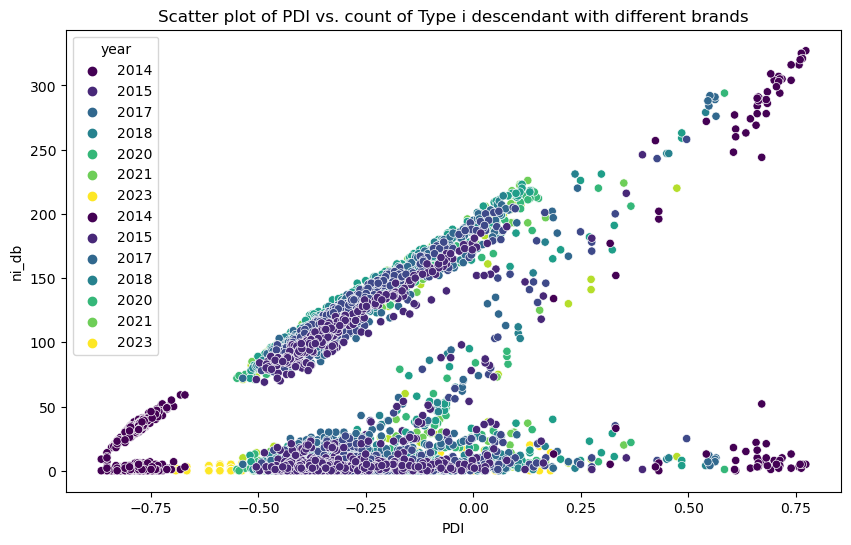

In [538]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
pdi_df = pd.read_csv(filepath+'PDI_df.csv')
pdi_df = pdi_df.dropna()

# 计算相关性及其 p 值
correlations = {}
for column in ['ni', 'ni_db', 'ni_sb']:
    corr, p_value = pearsonr(pdi_df['PDI'], pdi_df[column])
    correlations[column] = (corr.round(3), p_value)

# 创建相关性表
correlation_df = pd.DataFrame(correlations, index=['Correlation', 'p-value']).T

# 添加显著性标志
def significance_mark(p_value):
    if p_value < 0.001:
        return '***'  # 极其显著
    elif p_value < 0.01:
        return '**'   # 显著
    elif p_value < 0.05:
        return '*'    # 边缘显著
    else:
        return ''     # 不显著

correlation_df['Significance'] = correlation_df['p-value'].apply(significance_mark)
correlation_df.to_csv(filepath+'Ni_correlation_df.csv',index=False)
# 打印相关性表
print(correlation_df)
# 根据 year 聚合并绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdi_df, x='PDI', y='ni_db', hue='year', palette='viridis', markers=['o'])
sns.scatterplot(data=pdi_df, x='PDI', y='ni_sb', hue='year', palette='viridis', markers=['x'])
plt.title('Scatter plot of PDI vs. count of Type i descendant with different brands')
plt.xlabel('PDI')
plt.ylabel('ni_db')
#plt.savefig(filepath+f'PDI_Nidb_scatter.svg')
plt.show()




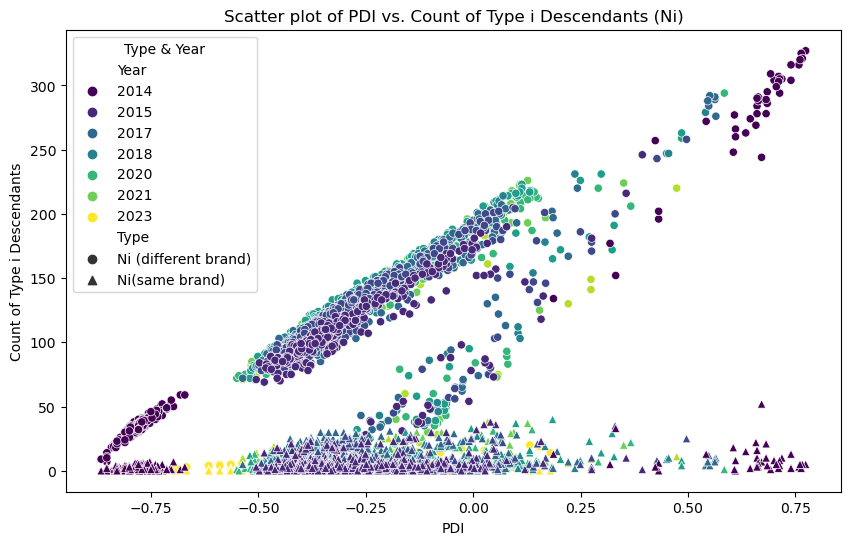

In [537]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 将 ni_db 和 ni_sb 转换为长格式数据
pdi_df_melted = pd.melt(pdi_df, id_vars=['PDI', 'year'], value_vars=['ni_db', 'ni_sb'], var_name='Type', value_name='Value')
pdi_df_melted['Year'] = pdi_df_melted['year']
# 替换变量标签
pdi_df_melted['Type'] = pdi_df_melted['Type'].replace({
    'ni_db': 'Ni (different brand)',
    'ni_sb': 'Ni(same brand)'
})

plt.figure(figsize=(10, 6))

# 绘制散点图，用不同的颜色表示不同的年，用不同的形状表示不同品牌和相同品牌的i类型后代的数量
sns.scatterplot(data=pdi_df_melted, x='PDI', y='Value', hue='Year', style='Type', palette='viridis', markers=['o', '^'])

plt.title('Scatter plot of PDI vs. Count of Type i Descendants (Ni)')
plt.xlabel('PDI')
plt.ylabel('Count of Type i Descendants')
plt.legend(title='Type & Year')
plt.savefig(filepath + 'PDI_ni_db_ni_sb_scatter.svg')
#plt.show()


In [ ]:
import pandas as pd
import scipy.stats as stats

# 假设 pdi_df 是你的数据集
pdi_df = pd.DataFrame({
    'PDI': [10, 20, 30, 40, 50],
    'ni': [1, 2, 3, 4, 5],
    'ni_db': [2, 4, 6, 8, 10],
    'ni_sb': [3, 6, 9, 12, 15]
})

# 计算相关性及其 p 值
correlations = {}
for column in ['ni', 'ni_db', 'ni_sb']:
    corr, p_value = stats.pearsonr(pdi_df['PDI'], pdi_df[column])
    correlations[column] = (corr, p_value)

# 创建相关性表
correlation_df = pd.DataFrame(correlations, index=['Correlation', 'p-value']).T

# 添加显著性标志
def significance_mark(p_value):
    if p_value < 0.001:
        return '***'  # 极其显著
    elif p_value < 0.01:
        return '**'   # 显著
    elif p_value < 0.05:
        return '*'    # 边缘显著
    else:
        return ''     # 不显著

correlation_df['Significance'] = correlation_df['p-value'].apply(significance_mark)

# 打印相关性表
print(correlation_df)


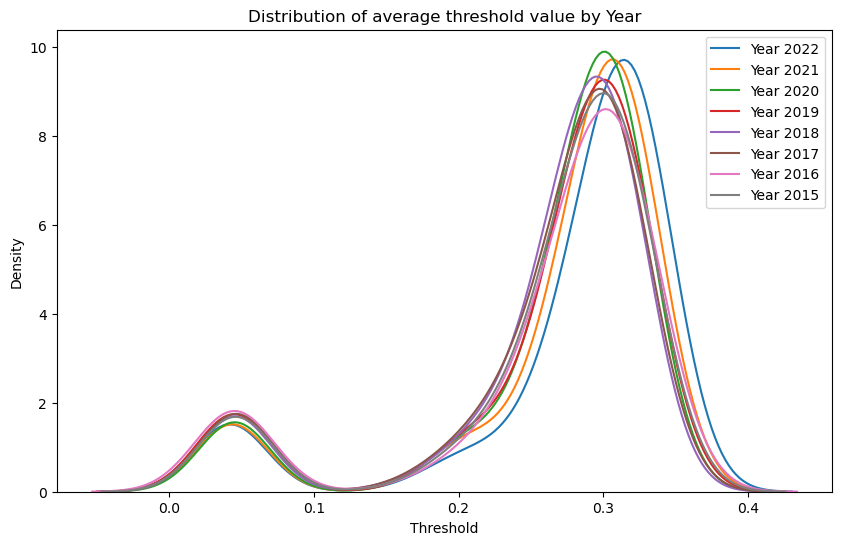

In [459]:
col_name = 'avg_threshold'
trend_df = pdi_df[(pdi_df['year']>2014)&(pdi_df['year']<2023)]
plt.figure(figsize=(10, 6))
for year in trend_df['year'].unique():
    sns.kdeplot(trend_df[trend_df['year'] == year][col_name], label=f'Year {year}')
plt.title('Distribution of average threshold value by Year')
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.legend()
plt.savefig(filepath+f'distribution_thresholds.svg')

In [465]:
def getstat(data, collst, newcollst, cartype):
    # 取得统计数据，collst：原始列名，newcollst：显示列名
    df = data.copy()
    for col in range(len(collst)):
        old_name = collst[col]
        new_name = newcollst[col]
        df.rename(columns={old_name: new_name}, inplace=True)
    collst = newcollst

    if cartype != 'all':
        df = df[(df.cartype == cartype) & (data.year > 1997) & (data.year < 2024)]
    else:
        df = df[(data.year > 1997) & (data.year < 2024)]

    stat_df = pd.DataFrame()
    new_df = df[collst]
    corr_matrix = new_df.corr().round(3)

    # 将所有为1的值替换为NaN
    corr_matrix[corr_matrix == 1] = np.nan

    lower_triangle = np.tril(np.ones(corr_matrix.shape), k=0).astype(bool)
    corr_matrix = corr_matrix.where(lower_triangle).fillna('')

    stat_df = pd.concat([df[collst].mean().round(3), df[collst].std().round(3), df[collst].max().round(3), df[collst].min().round(3), corr_matrix], axis=1)
    cols = ['Mean', 'SD', 'Max', 'Min'] + list(range(1, len(stat_df) + 1))
    stat_df.columns = cols
    stat_df.insert(0, 'Variable', stat_df.index)
    stat_df.reset_index(drop=True, inplace=True)
    stat_df.index += 1
    stat_df['Variable'] = stat_df.index.astype(str) + '. ' + stat_df['Variable']
    stat_df.set_index('Variable', inplace=True)

    return df.cartype.unique().tolist(), len(df), stat_df

In [471]:
weight = 'tf'
endyear = 2024
beginyear = 2013
col_dic = {
           'cd13.9_1':'PDI',
           'avg_wdis_rate':'Reduction Quality',#'Weighted lost gene rate',
           'avg_dis_rate':'Reduction Quantity',#'Unweighted lost gene rate',
           #'avg_dis_rate_diff':'Lost gene rate difference',
           'avg_winh_rate':'Retention Quality',#'Weighted inherited gene rate',
           'avg_inh_rate':'Retention Quantity',#'Unweighted inherited gene rate',
           #'avg_inh_rate_diff':'Inherited gene rate difference',
           'avg_wnew_rate':'Addition Quality',#'Weighted new gene rate',
           'avg_new_rate':'Addition Quantity',#'Unweighted new gene rate',
           #'avg_new_rate_diff':'New gene rate difference',
           'log_price':'Price(log)',
           'rate':'Review rate',
           'newgenecountrate': 'Creation Quantity',#'Brand new gene rate',
           'avg_anc_cd13.9_1':'Ancestor PDI',
          }
data = pd.read_csv(filepath+weight+'_product_regdata.csv')
#collst = ['cd13.9_1','avg_dis_rate_diff','avg_inh_rate_diff','avg_new_rate_diff','newgenecountrate','avg_anc_cd13.9_1']
#newcollst = ['CD','Lost gene rate difference','Inherited gene rate difference','New gene rate difference','Brand new gene rate','Ancestor PDI']
collst = list(col_dic.keys())
newcollst = list(col_dic.values())
cartype = 'all'
cartype_lst,count,stat_df = getstat(data.loc[(data['year'] > beginyear) & (data['year'] < endyear) & (~data['vfm'].isna())],collst,newcollst,cartype)
#print(cartype_lst,count)
stat_df.to_csv(filepath+weight+'_stat_new_df.csv')
stat_df

,Mean,SD,Max,Min,1,2,3,4,5,6,7,8,9,10,11
Variable,,,,,,,,,,,,,,,
1. PDI,-0.296,0.173,0.589,-0.795,,,,,,,,,,,
2. Reduction Quality,0.061,0.052,0.543,0.000,-0.073,,,,,,,,,,
3. Reduction Quantity,0.197,0.122,0.853,0.009,0.004,0.83,,,,,,,,,
4. Retention Quality,0.935,0.050,1.000,0.551,0.009,-0.737,-0.744,,,,,,,,
5. Retention Quantity,0.789,0.125,0.991,0.118,-0.01,-0.802,-0.979,0.776,,,,,,,
6. Addition Quality,0.065,0.050,0.449,0.000,-0.009,0.737,0.744,-1.0,-0.776,,,,,,
7. Addition Quantity,0.211,0.125,0.882,0.009,0.01,0.802,0.979,-0.776,-1.0,0.776,,,,,
8. Price(log),10.740,0.687,14.164,9.392,-0.039,-0.009,-0.014,0.005,0.014,-0.005,-0.014,,,,
9. Review rate,4.624,0.362,5.000,1.000,0.051,0.0,-0.01,0.009,0.004,-0.009,-0.004,-0.012,,,


In [470]:
weight = 'tfidf'
endyear = 2024
beginyear = 2013
col_dic = {
           'cd13.9_1':'PDI',
           'avg_wdis_rate':'Reduction Quality',#'Weighted lost gene rate',
           'avg_dis_rate':'Reduction Quantity',#'Unweighted lost gene rate',
           #'avg_dis_rate_diff':'Lost gene rate difference',
           'avg_winh_rate':'Retention Quality',#'Weighted inherited gene rate',
           'avg_inh_rate':'Retention Quantity',#'Unweighted inherited gene rate',
           #'avg_inh_rate_diff':'Inherited gene rate difference',
           'avg_wnew_rate':'Addition Quality',#'Weighted new gene rate',
           'avg_new_rate':'Addition Quantity',#'Unweighted new gene rate',
           #'avg_new_rate_diff':'New gene rate difference',
           'log_price':'Price(log)',
           'rate':'Review rate',
           'newgenecountrate': 'Creation Quantity',#'Brand new gene rate',
           'avg_anc_cd13.9_1':'Ancestor PDI',
          }
data = pd.read_csv(filepath+weight+'_product_regdata.csv')
#collst = ['cd13.9_1','avg_dis_rate_diff','avg_inh_rate_diff','avg_new_rate_diff','newgenecountrate','avg_anc_cd13.9_1']
#newcollst = ['CD','Lost gene rate difference','Inherited gene rate difference','New gene rate difference','Brand new gene rate','Ancestor PDI']
collst = list(col_dic.keys())
newcollst = list(col_dic.values())
cartype = 'all'
cartype_lst,count,stat_df = getstat(data.loc[(data['year'] > beginyear) & (data['year'] < endyear) & (~data['vfm'].isna())],collst,newcollst,cartype)
#print(cartype_lst,count)
stat_df.to_csv(filepath+weight+'_stat_new_df.csv')
stat_df

,Mean,SD,Max,Min,1,2,3,4,5,6,7,8,9,10,11
Variable,,,,,,,,,,,,,,,
1. PDI,-0.296,0.173,0.589,-0.795,,,,,,,,,,,
2. Reduction Quality,0.195,0.162,0.972,0.004,0.266,,,,,,,,,,
3. Reduction Quantity,0.197,0.122,0.853,0.009,0.004,0.829,,,,,,,,,
4. Retention Quality,0.782,0.164,0.998,0.029,-0.269,-0.929,-0.787,,,,,,,,
5. Retention Quantity,0.789,0.125,0.991,0.118,-0.01,-0.81,-0.979,0.81,,,,,,,
6. Addition Quality,0.218,0.164,0.971,0.002,0.269,0.929,0.787,-1.0,-0.81,,,,,,
7. Addition Quantity,0.211,0.125,0.882,0.009,0.01,0.81,0.979,-0.81,-1.0,0.81,,,,,
8. Price(log),10.740,0.687,14.164,9.392,-0.039,-0.025,-0.014,0.017,0.014,-0.017,-0.014,,,,
9. Review rate,4.624,0.362,5.000,1.000,0.051,-0.003,-0.01,0.003,0.004,-0.003,-0.004,-0.012,,,


In [ ]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import math
beginyear = 2013
endyear = 2024
node_df = key_products_df[(key_products_df.year>=beginyear)&(key_products_df.year<=endyear)].copy()
node_df['index'] = node_df['productname']
node_df.set_index('index', inplace=True)
yearlst = sorted(node_df.year.unique().tolist())
#input_temp_title = str(beginyear)+'_'+str(endyear)
#filepath = path#+input_temp_title
year_norm = False
norm_x,norm_y,name_df,idx_df = getdatasets(node_df,beginyear,endyear,filepath,input_temp_title)#,year_norm=year_norm)
colst = norm_x.columns.tolist()  

Start loading norm_x and norm_y!
Load C:/Users/heyouwei/code/car/20230415/2013_2024_period/2013_2024_period_normx.csv
Load C:/Users/heyouwei/code/car/20230415/2013_2024_period/2013_2024_period_normy.csv
Load C:/Users/heyouwei/code/car/20230415/2013_2024_period/2013_2024_period_name.csv


In [195]:
#建立ancestors_df，记录与每个product相似度最高的nlarge个ancestor的信息
data = node_df.reset_index()#pd.read_csv(filepath+'nodecdtaxa.csv') 
tfweight_df =  pd.read_csv(filepath+'fqyearweight_df.csv',low_memory=False) 
tfidfweight_df =  pd.read_csv(filepath+'tfidfweight_df.csv',low_memory=False) 
weight = 'tf'#'tfidf','tf'
if weight == 'tf': 
    fqweight_df = tfweight_df
else:
    fqweight_df = tfidfweight_df

cd_df = pd.read_csv(filepath+'newcd_data.csv',low_memory=False)
cd_lst = ['cd13.9_1','cd13.1_1','cd13.8_1']
#year_lst = sorted(data[(data.year>=beginyear)&(data.year<=endyear)].year.unique().tolist())
#for year in year_lst:
ancestors_df = pd.DataFrame()
nlarge = 3 #寻找前多少个最大相似性的ancestor
col_lst = norm_x.columns.tolist()
if os.path.exists(filepath+weight+'_pweight_df.csv') and os.path.exists(filepath+'wnorm_x.csv'):
    print('Loading '+filepath+weight+'_wnorm_x.csv')
    wnorm_x = pd.read_csv(filepath+weight+'_wnorm_x.csv',low_memory=False)#wnorm_x是带weight的chromosome
    print('Loading '+filepath+weight+'_pweight_df.csv')
    pweight_df = pd.read_csv(filepath+weight+'_pweight_df.csv',low_memory=False)
else:
    #wnorm_x是带weight的chromosome,pweight_df.csv是所有product的所有基因的weight
    print('Generating wnorm_x.csv and pweight_df.csv')
    pweight_df = pd.DataFrame()
    for idx in tqdm(data.index.tolist()):
        year = data.loc[idx,'year']
        weights = fqweight_df[fqweight_df.year==year][col_lst]
        pweight_df = pd.concat([pweight_df,weights])
    pweight_df.index = data.index
    print('Saving '+filepath+weight+'_pweight_df.csv')
    pweight_df.to_csv(filepath+weight+'_pweight_df.csv')
    wnorm_x = norm_x*pweight_df
    wnorm_x.fillna(0, inplace=True)
    print('Saving '+filepath+weight+'_wnorm_x.csv')
    wnorm_x.to_csv(filepath+weight+'_wnorm_x.csv',index=False)
oneweight_df = norm_x.copy()    
oneweight_df[:] = 1    

Loading C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_wnorm_x.csv
Loading C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_pweight_df.csv


In [202]:
for idx in tqdm(data.index.tolist()[:]):
    year = data.loc[idx,'year']
    #foc_weights = fqweight_df[fqweight_df.year==year].loc[:,col_lst].values
    productname = data.loc[idx,'productname']
    #求focal的PDI
    foc_cd_lst = getcd(cd_df,productname,cd_lst)
    ancestorid_lst = data[data.year<year].index.tolist()
    if len(ancestorid_lst)>0:
        #cos_sim_lst = cosine_similarity(norm_x.loc[[idx],:],norm_x.loc[ancestorid_lst,:])[0].tolist()#求出focal与其ancestors的相似度列表
        #largest_n = sorted(cos_sim_lst, reverse=True)[:nlarge]#求出cos_sim_lst中最大的nlarge个数
        #indices = [cos_sim_lst.index(x) for x in largest_n]#求出cos_sim_lst中最大的nlarge个数的顺序
        # 找到前nlarge个最大的数及其索引
        values, indices = torch.topk(adj_x[ancestorid_lst,idx], k=nlarge)
        dic = {
            'index':idx,
            'productname':productname,
            'year':year,
            }
        
        for cd_idx in range(len(cd_lst)):
            dic[cd_lst[cd_idx]] = foc_cd_lst[cd_idx]
            
        for n in range(nlarge):#循环三个相似度最大的ancestor
            #anc_id =  ancestorid_lst[indices[n]]#top n ancestor id
            anc_id = ancestorid_lst[indices[n].item()]
            anc_name = data.loc[anc_id,'productname']
            #求ancestor的PDI
            anc_cd_lst = getcd(cd_df,anc_name,cd_lst)
            anc_year = data[data.index==anc_id].year.tolist()[0]            
            dic['top'+str(n)+'_id'] = anc_id
            dic['top'+str(n)+'_name'] = anc_name
            for cd_idx in range(len(anc_cd_lst)):
                if not math.isnan(anc_cd_lst[cd_idx]):
                    dic['top'+str(n)+'_anc_'+cd_lst[cd_idx]] = anc_cd_lst[cd_idx]
                    if not math.isnan(foc_cd_lst[cd_idx]):
                        dic['top'+str(n)+'_'+cd_lst[cd_idx]+'_diff'] = foc_cd_lst[cd_idx] - anc_cd_lst[cd_idx]#用foc的PDI减去anc的PDI
                        dic['top'+str(n)+'_'+cd_lst[cd_idx]+'_diff_ratio'] = (foc_cd_lst[cd_idx] - anc_cd_lst[cd_idx])/(anc_cd_lst[cd_idx]+1)

            #dic['top'+str(n)+'_sim'] = largest_n[n] #top n ancestor similarity
            dic['top'+str(n)+'_sim'] = values[n].item() #top n ancestor similarity
            dic['top'+str(n)+'_year'] = anc_year
            dic['top'+str(n)+'_yeardiff'] = year-anc_year
            #anc_weights = fqweight_df[fqweight_df.year==anc_year].loc[:,col_lst].values
            dic['top'+str(n)+'_weigtsim'] = cosine_similarity(wnorm_x.loc[[anc_id],col_lst].values,wnorm_x.loc[[idx],col_lst])[0][0]
            #dic['top'+str(n)+'_weigtsim'] = cosine_similarity(norm_x.loc[[anc_id],col_lst].values*anc_weights,norm_x.loc[[idx],col_lst]*foc_weights)[0][0]
            dis_rate,inh_rate,new_rate,dis_count,inh_count,new_count,total_count = getancestorrate(norm_x,oneweight_df,anc_id,idx)
            dic['top'+str(n)+'_dis_rate'] = dis_rate #消失基因比率
            dic['top'+str(n)+'_inh_rate'] = inh_rate #遗传基因比率
            dic['top'+str(n)+'_new_rate'] = new_rate #新基因比率
            dic['top'+str(n)+'_dis_count'] = dis_count #消失基因数
            dic['top'+str(n)+'_inh_count'] = inh_count #遗传基因数
            dic['top'+str(n)+'_new_count'] = new_count #新基因数
            dic['top'+str(n)+'_total_count'] = total_count #总基因数
            #wdis_rate,winh_rate,wnew_rate = getancestorrate(norm_x,pweight_df[col_lst],anc_id,idx)
            wdis_rate,winh_rate,wnew_rate,wdis_count,winh_count,wnew_count,wtotal_count  = getancestorrate(wnorm_x,oneweight_df,anc_id,idx)
            dic['top'+str(n)+'_wdis_rate'] = wdis_rate #weighted消失基因比率
            dic['top'+str(n)+'_winh_rate'] = winh_rate #weighted遗传基因比率
            dic['top'+str(n)+'_wnew_rate'] = wnew_rate #weighted新基因比率
            dic['top'+str(n)+'_wdis_count'] = wdis_count #weighted消失基因数
            dic['top'+str(n)+'_winh_count'] = winh_count #weighted遗传基因数
            dic['top'+str(n)+'_wnew_count'] = wnew_count #weighted新基因数
            dic['top'+str(n)+'_wtotal_count'] = wtotal_count #weighted总基因数
        ancestors_df = pd.concat([ancestors_df,pd.DataFrame([dic])])
'''
ycol_lst = ['_sim','_weigtsim','_dis_rate','_inh_rate','_new_rate','_wdis_rate','_winh_rate','_wnew_rate'] + ['_anc_'+col for col in cd_lst] 
for col in ycol_lst:#求平均
    ancestors_df['avg'+col] = ancestors_df[[f'top{n}{col}' for n in range(nlarge)]].mean(axis=1)
for col in  [col+'_diff' for col in cd_lst] +  [col+'_diff_ratio' for col in cd_lst]:#求平均anc的cd与的foccd的diff和diff ratio  
    ancestors_df['avg'+col] = ancestors_df[[f'top{n}_{col}' for n in range(nlarge)]].mean(axis=1)
#求weight与unweight的diff
ancestors_df['avg_sim_diff_ratio'] = (ancestors_df['avg_weigtsim'] - ancestors_df['avg_sim'])/ancestors_df['avg_sim']
ancestors_df['avg_dis_rate_diff'] = ancestors_df['avg_wdis_rate'] - ancestors_df['avg_dis_rate']
ancestors_df['avg_inh_rate_diff'] = ancestors_df['avg_winh_rate'] - ancestors_df['avg_inh_rate']
ancestors_df['avg_new_rate_diff'] = ancestors_df['avg_wnew_rate'] - ancestors_df['avg_new_rate']
ancestors_df['avg_sim_diff'] = ancestors_df['avg_weigtsim'] - ancestors_df['avg_sim']      

ancestors_df.set_index('index', inplace=True)
ancestors_df.to_csv(filepath+weight+'_ancestors_df.csv')
print('Saved file:',filepath+weight+'_ancestors_df.csv')
'''

100%|██████████| 4496/4496 [2:56:43<00:00,  2.36s/it]  


"\nycol_lst = ['_sim','_weigtsim','_dis_rate','_inh_rate','_new_rate','_wdis_rate','_winh_rate','_wnew_rate'] + ['_anc_'+col for col in cd_lst] \nfor col in ycol_lst:#求平均\n    ancestors_df['avg'+col] = ancestors_df[[f'top{n}{col}' for n in range(nlarge)]].mean(axis=1)\n\nfor col in  [col+'_diff' for col in cd_lst] +  [col+'_diff_ratio' for col in cd_lst]:#求平均anc的cd与的foccd的diff和diff ratio  \n    ancestors_df['avg'+col] = ancestors_df[[f'top{n}_{col}' for n in range(nlarge)]].mean(axis=1)\n\n\n#求weight与unweight的diff\nancestors_df['avg_sim_diff_ratio'] = (ancestors_df['avg_weigtsim'] - ancestors_df['avg_sim'])/ancestors_df['avg_sim']\nancestors_df['avg_dis_rate_diff'] = ancestors_df['avg_wdis_rate'] - ancestors_df['avg_dis_rate']\nancestors_df['avg_inh_rate_diff'] = ancestors_df['avg_winh_rate'] - ancestors_df['avg_inh_rate']\nancestors_df['avg_new_rate_diff'] = ancestors_df['avg_wnew_rate'] - ancestors_df['avg_new_rate']\nancestors_df['avg_sim_diff'] = ancestors_df['avg_weigtsim'] - ance

In [210]:
ycol_lst = ['_sim','_weigtsim','_dis_rate','_inh_rate','_new_rate','_wdis_rate','_winh_rate','_wnew_rate','_dis_count','_inh_count','_new_count','_total_count','_wdis_count','_winh_count','_wnew_count','_wtotal_count'] + ['_anc_'+col for col in cd_lst] 
for col in ycol_lst:#求平均
    ancestors_df['avg'+col] = ancestors_df[[f'top{n}{col}' for n in range(nlarge)]].mean(axis=1)
for col in  [col+'_diff' for col in cd_lst] +  [col+'_diff_ratio' for col in cd_lst]:#求平均anc的cd与的foccd的diff和diff ratio  
    ancestors_df['avg'+col] = ancestors_df[[f'top{n}_{col}' for n in range(nlarge)]].mean(axis=1)
ancestors_df.set_index('index', inplace=True)
ancestors_df.to_csv(filepath+weight+'_ancestors_df_new.csv')
print('Saved file:',filepath+weight+'_ancestors_df_new.csv')

C:\Users\heyouwei\AppData\Local\Temp\ipykernel_134048\711702735.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ancestors_df['avg'+col] = ancestors_df[[f'top{n}{col}' for n in range(nlarge)]].mean(axis=1)
C:\Users\heyouwei\AppData\Local\Temp\ipykernel_134048\711702735.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ancestors_df['avg'+col] = ancestors_df[[f'top{n}_{col}' for n in range(nlarge)]].mean(axis=1)
C:\Users\heyouwei\AppData\Local\Temp\ipykernel_134048\711702735.py:5: PerformanceWarning: DataFrame is highly fragm

Saved file: C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_ancestors_df_new.csv


In [548]:
#ancestors_df = ancestors_df.reset_index()
link_df = pd.DataFrame()
for idx in tqdm(ancestors_df.index.tolist()):
    for anc_num in range(3):
        foc_year,foc_name = ancestors_df.loc[idx,['year','productname']]
        foc_brand = data[data['productname']==foc_name]['brand'].tolist()[0]
        product_idx = data[data['productname']==foc_name].index.tolist()[0]
        cd = ancestors_df.loc[idx,'cd13.9_1']
        anc_name,anc_year,sim = ancestors_df.loc[idx,['top'+str(anc_num)+'_name','top'+str(anc_num)+'_year','top'+str(anc_num)+'_sim']]
        preproduct_idx = data[data['productname']==anc_name].index.tolist()[0] 
        anc_brand = data[data['productname']==anc_name]['brand'].tolist()[0]
        dic = {'foc_name':foc_name,
               'foc_brand':foc_brand,
               'foc_year':foc_year,
               'product_idx':product_idx,
               'preproduct_idx':preproduct_idx,
               'cd':cd,
               'anc_name':anc_name,
               'anc_brand':anc_brand,
               'anc_year':anc_year,
               'sim':sim,
               'anc_num':anc_num
               }
        link_df = pd.concat([link_df,pd.DataFrame([dic])])
link_df = link_df.reset_index()

        

  0%|          | 0/4155 [00:00<?, ?it/s]

100%|██████████| 4155/4155 [02:06<00:00, 32.83it/s]


In [263]:
len(data[data['brand']=='tesla'])

30

C:/Users/heyouwei/code/car/20230415/2013_2024_period/phylonet_tesla.svg


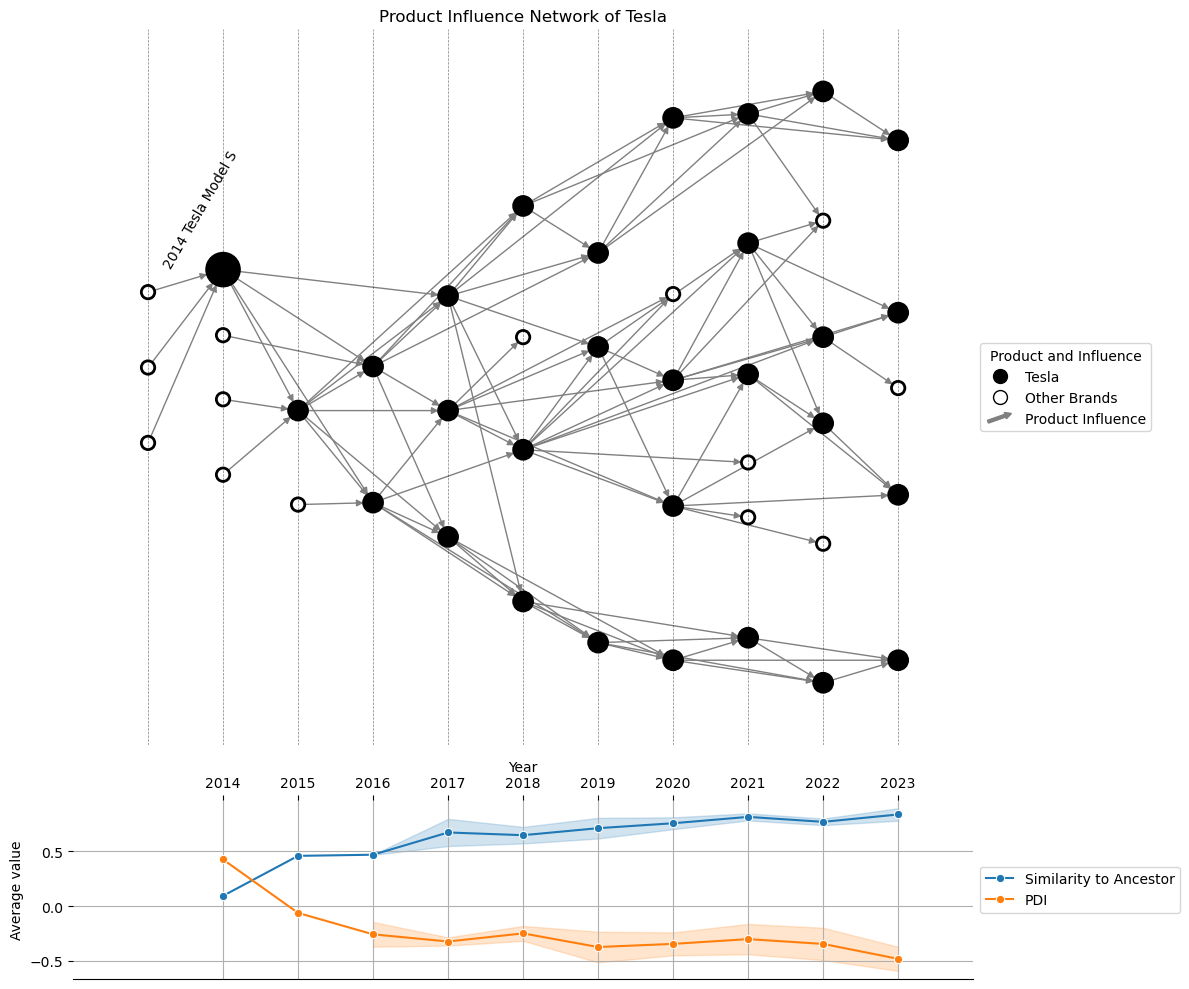

In [572]:
col_name_dic = {'price':'Price','sim':'Similarity to Ancestor','cd':'PDI'}
drawtree(link_df, 'tesla', ['sim','cd'], '2014 Tesla Model S', data)
#drawtree(link_df, 'chevrolet', ['sim','cd'], '2014 Chevrolet Spark EV', data)

# visualization

In [571]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerPatch
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        return [FancyArrowPatch((xdescent, ydescent), (xdescent + width, ydescent + height),
                                mutation_scale=orig_handle.get_mutation_scale(),
                                color=orig_handle.get_edgecolor(),
                                lw=orig_handle.get_linewidth())]
def drawtree(sim_df, select_brand, select_cols, big_node, product_df, node_size=20):
    df = sim_df[(sim_df['foc_brand'] == select_brand) | (sim_df['anc_brand'] == select_brand)]
    # 创建有向图
    G = nx.DiGraph()

    # 添加节点和边，并设置标签
    for _, row in df.iterrows():
        '''
        G.add_node(row['preproduct_idx'], year=row['anc_year'], brand=row['anc_brand'],  
                   #cols=[product_df.loc[row['preproduct_idx'], col] for col in select_cols], 
                   cols=[sim_df[sim_df['preproduct_idx']==row['preproduct_idx']][col].tolist()[0] for col in select_cols], 
                   model=row['anc_name'])
        G.add_node(row['product_idx'], year=row['foc_year'], brand=row['foc_brand'],  
                   #cols=[product_df.loc[row['product_idx'], col] for col in select_cols], 
                   cols=[row[col] for col in select_cols], 
                   model=row['foc_name'])
        G.add_edge(row['preproduct_idx'], row['product_idx'])
        '''
        G.add_node(row['anc_name'], year=row['anc_year'], brand=row['anc_brand'],  
                   #cols=[product_df.loc[row['preproduct_idx'], col] for col in select_cols], 
                   cols=[sim_df[sim_df['anc_name']==row['anc_name']][col].tolist()[0] for col in select_cols], 
                   model=row['anc_name'])
        G.add_node(row['foc_name'], year=row['foc_year'], brand=row['foc_brand'],  
                   #cols=[product_df.loc[row['product_idx'], col] for col in select_cols], 
                   cols=[row[col] for col in select_cols], 
                   model=row['foc_name'])
        G.add_edge(row['anc_name'], row['foc_name'])
    # 获取节点的年份属性和品牌
    years = nx.get_node_attributes(G, 'year')
    brands = nx.get_node_attributes(G, 'brand')
    models = nx.get_node_attributes(G, 'model')
    cols = nx.get_node_attributes(G, 'cols')

    node_size = node_size * 200 / len(G.nodes())
    #node_sizes = [node_size * 6 if node == big_node else node_size for node in G.nodes()]
    node_sizes = [
    node_size * 6 if node == big_node else
    (node_size * 2 if brands[node] == select_brand else node_size)
    for node in G.nodes()
]
    # 使用 graphviz_layout 布局，设置 rankdir 为 LR（从左到右）
    pos = graphviz_layout(G, prog='dot', args='-Grankdir=LR')

    # 调整节点位置，使相同年份的节点在同一列，并留有空隙
    year_positions = {}
    for node, (x, y) in pos.items():
        year = years[node]
        if year not in year_positions:
            year_positions[year] = []
        year_positions[year].append((y, node))

    for year, nodes in year_positions.items():
        nodes.sort()  # 按y坐标排序
        for i, (y, node) in enumerate(nodes):
            pos[node] = (year, y + i * 100)  # 使用年份作为x坐标，并在y坐标上留有空隙

    # 绘制系统生育树
    fig, (ax_tree, ax_trend) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

    # 设置节点的形状，select_brand 为实心圆，其他为空心圆
    node_shapes = ['o' if brands[node] == select_brand else 'o' for node in G.nodes()]
    node_colors = ['black' if brands[node] == select_brand else 'white' for node in G.nodes()]
    node_edgecolors = ['black' for _ in G.nodes()]

    nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, 
            edge_color='gray', ax=ax_tree, node_shape='o', linewidths=2, edgecolors=node_edgecolors)

    # 显示根节点的 model 属性标签
    for node in G.nodes():
        if node == big_node:  # 如果节点是 big_node
            x, y = pos[node]
            ax_tree.text(x-.3, y - 1.7, models[node].replace(' (','\n('), fontsize=10, rotation=60, 
                         verticalalignment='bottom', horizontalalignment='center')
        elif (G.in_degree(node) == 0) and (brands[node] == select_brand):  # 其他根节点逻辑保持不变
            x, y = pos[node]
            ax_tree.text(x-.3, y - 1.7, models[node].replace(' (','\n('), fontsize=10, rotation=60, 
                         verticalalignment='bottom', horizontalalignment='center')

    min_year = min(years.values())
    max_year = max(years.values())
    ax_tree.set_xlim([min_year - 1, max_year + 1])

    for year in range(min_year, max_year + 1):
        ax_tree.axvline(x=year, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    ax_tree.xaxis.set_visible(False)
    ax_tree.spines['bottom'].set_visible(False)

    # 创建图例，实心圆表示 select_brand，空心圆表示其他品牌
    #select_brand_patch = mpatches.Circle((0, 0), radius=0.5, color='black', label=select_brand, linestyle='None')
    #other_brand_patch = mpatches.Circle((0, 0), radius=0.5, edgecolor='black', facecolor='white', label='Other Brands')

    #ax_tree.legend(handles=[select_brand_patch, other_brand_patch], title="Brand", loc='center left', bbox_to_anchor=(1, 0.5))
    select_brand_patch = Line2D([0], [0], marker='o', color='black', markersize=10, label=select_brand.capitalize(), linestyle='None')  # 实心圆
    other_brand_patch = Line2D([0], [0], marker='o', color='black', markersize=10, markerfacecolor='white', label='Other Brands', linestyle='None')  # 空心圆
    edge_patch = FancyArrowPatch((0, 0), (1, 0), color='gray', arrowstyle='-|>', mutation_scale=8, label='Product Influence', transform=fig.transFigure, lw=1.5)   # 边的图例
    # 添加图例
    #ax_tree.legend(handles=[select_brand_patch, other_brand_patch,edge_patch], title="Brand", loc='center left', bbox_to_anchor=(1, 0.5))
    ax_tree.legend(handles=[select_brand_patch, other_brand_patch, edge_patch], title="Product and Influence", loc='center left', bbox_to_anchor=(1, 0.5), handler_map={FancyArrowPatch: HandlerArrow()})
    ax_tree.set_title('Product Influence Network of ' + select_brand.capitalize())
    
    foc_years = {node: years[node] for node in G.nodes() if brands[node] == select_brand}
    for col_idx in range(len(select_cols)):
        foc_cols = {node: cols[node][col_idx] for node in G.nodes() if brands[node] == select_brand}
        foc_data = pd.DataFrame({'year': foc_years.values(), 'cols': foc_cols.values()})#.sort_values(by='year')
        sns.lineplot(data=foc_data, x='year', y='cols', marker='o', ax=ax_trend, errorbar='sd', label=col_name_dic[select_cols[col_idx]])
        if 'result_df' in vars():
            result_df = pd.merge(result_df,foc_data.rename(columns={'cols':col_name_dic[select_cols[col_idx]]}).groupby('year').mean().reset_index(),on='year',how='inner')
        else:
            result_df = foc_data.rename(columns={'cols':col_name_dic[select_cols[col_idx]]}).groupby('year').mean().reset_index()
    ax_trend.set_xlabel('Year')
    ax_trend.set_ylabel('Average value')

    ax_trend.spines['left'].set_visible(False)
    ax_trend.spines['right'].set_visible(False)
    ax_trend.spines['top'].set_visible(False)

    ax_trend.set_xticks(range(min(foc_data['year']), max(foc_data['year']) + 1))
    ax_trend.xaxis.set_ticks_position('top')
    ax_trend.xaxis.set_label_position('top')

    ax_trend.set_title('')
    ax_trend.grid(True)
    ax_trend.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    #plt.show()
    plt.savefig(filepath+f'phylonet_{select_brand}.svg')#, dpi=300)
    print(filepath+f'phylonet_{select_brand}.svg')
    #return result_df

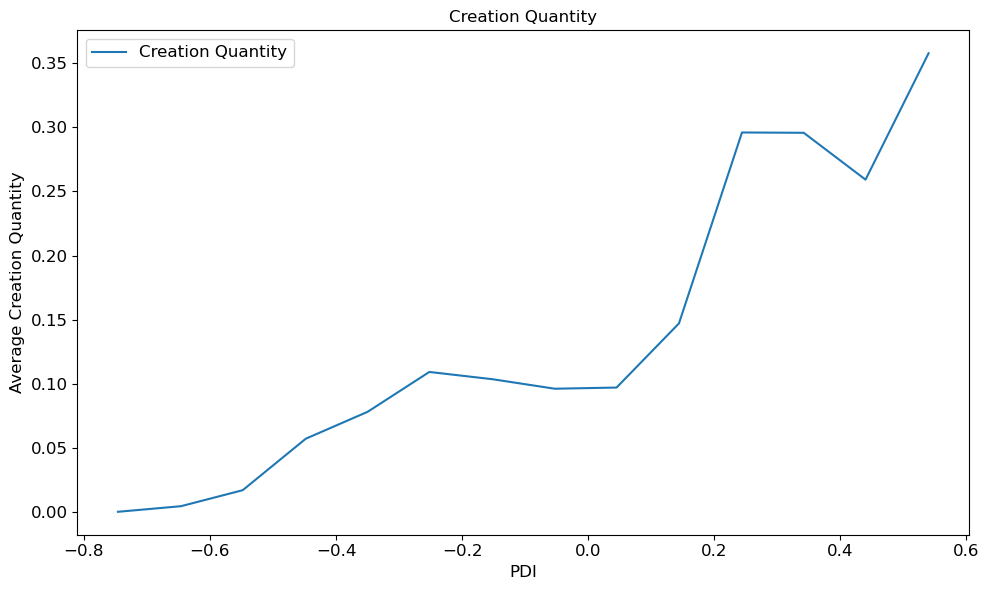

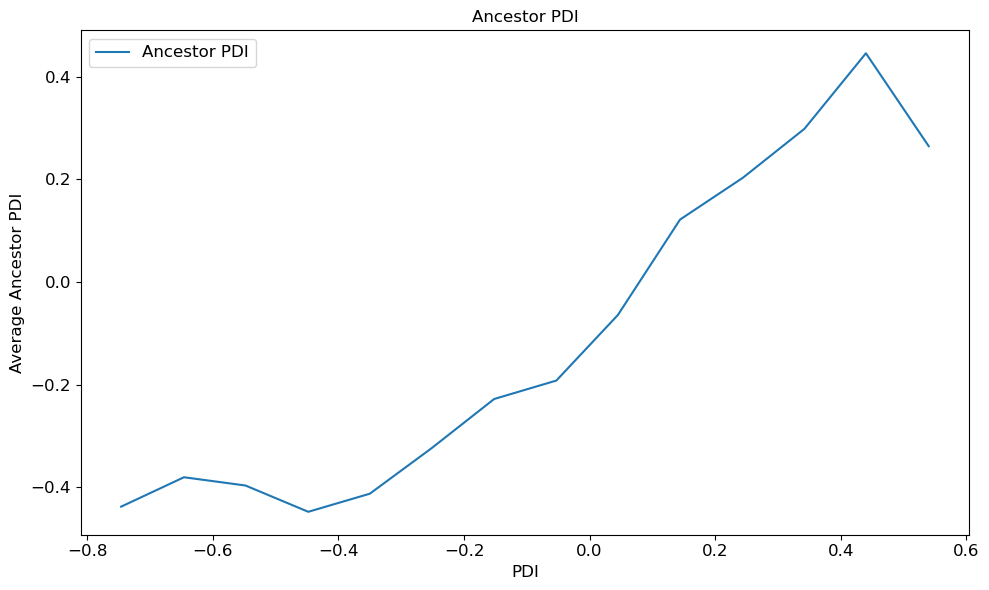

In [482]:
def getavgdf(df,col_lst,n,xcol):#给df分组并求每组的平均值，列为col_lst，分n组，根据xcol列的最大值与最小值平均分n组，返回分组计算后的df
    avg_df = pd.DataFrame()
    # 创建x的区间
    bins = np.linspace(df[xcol].min(), df[xcol].max(), n)  # 将x的范围分成n个区间
    df['x_bins'] = pd.cut(df[xcol], bins)
    
    avg_df['count'] = df['x_bins'].value_counts(sort=False)
    
    for y_col in col_lst+[xcol]:
        # 计算每个x值对应的y的平均值
        avg_df[y_col] = df.groupby('x_bins', observed=False)[y_col].mean()
    avg_df['x_value'] = [round(interval.mid,3) for interval in avg_df[y_col].index]
    #avg_df.index = avg_df['x_value']
    return avg_df
#col_lst = ['avg_new_rate_diff','avg_inh_rate_diff','avg_dis_rate_diff','avg_sim_diff']
#xcol = 'cd13.8_1'
#n = 9
#data = pd.read_csv(filepath+'product_regdata.csv')
#df = data[(data.year>2013)&(data.year<2024)].copy()
#avg_df = getavgdf(data,col_lst,n,xcol)
'''
# 绘制图形
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
#avg_df['x_value'].plot(kind='bar', ax=ax1)
avg_df[['avg_new_rate_diff', 'avg_inh_rate_diff']].plot(kind='line', ax=ax1)
avg_df['count'].plot(kind='bar', ax=ax2)
ax1.set_ylabel('x_value')
ax2.set_ylabel('avg_new_rate_diff'+'and'+'avg_inh_rate_diff')
plt.show()        
'''

def drawplot(df,xcol,ycol_lst,barcol,col_dic,x_name='PDI',smooth=False,legendpos='best'):
    #画图，df为按pdi分组平均值的各项数值，xcol：横轴坐标列，ycol_lst：需要表示的参数列（共同纵坐标），barcol：画bar图的count列，col_dic：列名字典,x_name:x轴的名字,smooth:是否做平滑处理，legendpos:图例位置
    from scipy.interpolate import make_interp_spline
    # 创建一个figure对象
    fig = plt.figure(figsize=(10, 6)) # 设置画板大小为10*6英寸

    # 创建一个子图对象
    ax1 = fig.add_subplot(111) # 将画板划分为1*1，ax1表示第一个子图
    #ax3 = ax1.twinx() # 创建一个共享x轴的第三个y轴
    for ycol in ycol_lst:
        if smooth==True:
            # 平滑处理
            m = make_interp_spline(df[xcol], df[ycol])
            xs = np.linspace(df[xcol].min(), df[xcol].max(), len(df)*5)
            ys = m(xs)
            ax1.plot(xs, ys, label=col_dic[ycol])
        else:
            # 绘制连线图
            ax1.plot(df[xcol], df[ycol], label=col_dic[ycol])
    # 绘制柱状图
    #bar_container = ax3.bar(df[xcol], df[barcol], width=0.6/(len(df)-1), alpha=0.5, label='Product count')
    #ax3.bar_label(bar_container)
    ax1.legend(handles=ax1.get_legend_handles_labels()[0] , loc=legendpos, fontsize='large')
    #ax1.legend(handles=ax1.get_legend_handles_labels()[0] + ax3.get_legend_handles_labels()[0], loc=legendpos) # 在最佳位置显示所有的图例
    # 设置坐标轴标签
    ax1.set_xlabel(x_name, fontsize='large') # 设置横坐标轴标签为cd13.8_1
    ax1.set_ylabel('Average '+col_dic[ycol_lst[0]], fontsize='large') # 设置连线图纵坐标轴标签为value
    #ax3.set_ylabel('count values') # 设置柱状图纵坐标轴标签为count values
    # 设置刻度大小
    ax1.tick_params(axis='both', which='major', labelsize='large')

    # 设置子图标题
    ax1.set_title(col_dic[ycol_lst[0]], fontsize='large') # 设置子图标题为df的连线图和柱状图
    #plt.axvline(x=0, color='black',linestyle='--')
    # 显示图形
    #plt.show() # 显示图形
    # 调整布局以减少空白
    plt.tight_layout()
    #plt.show()
    plt.savefig(filepath+col_dic[ycol_lst[0]]+'.svg', format='svg', bbox_inches='tight')



col_dic = {'avg_new_rate_diff':'New gene rate difference',
           'avg_dis_rate_diff':'Lost gene rate difference',
           'avg_inh_rate_diff':'Inherited gene rate difference',
           'avg_weigtsim':'Weighted similarity',
           'avg_sim':'Unweighted similarity',
           'avg_dis_rate':'Lost gene rate',
           'avg_wdis_rate':'Weighted lost gene rate',
           'avg_inh_rate':'Inherited gene rate',
           'avg_winh_rate':'Weighted inherited gene rate',
           'avg_sim_diff':'Similarity difference',
           'avg_new_rate':'New gene rate',
           'avg_wnew_rate':'Weighted new gene rate',
           'newgenecountrate':'Creation Quantity',
           'cd13.9_1':'PDI',
           'avg_anc_cd13.9_1':'Ancestor PDI',
           'avg_cd13.9_1_diff':'PDI difference',
           'normyear_avg_new_rate_diff':'Relative new gene rate difference',
           'normyear_avg_dis_rate_diff':'Relative lost gene rate difference',
           'normyear_avg_inh_rate_diff':'Relative inherited gene rate difference',
           'normyear_avg_weigtsim':'Relative weighted similarity',
           'normyear_avg_sim':'Relative unweighted similarity',
           'normyear_avg_dis_rate':'Relative lost gene rate',
           'normyear_avg_wdis_rate':'Relative weighted lost gene rate',
           'normyear_avg_inh_rate':'Relative inherited gene rate',
           'normyear_avg_winh_rate':'Relative weighted inherited gene rate',
           'normyear_avg_sim_diff':'Relative similarity difference',
           'normyear_avg_new_rate':'Relative new gene rate',
           'normyear_avg_wnew_rate':'Relative weighted new gene rate',
           'avg_anc_cd13.9_1':"Ancestor PDI"
           }
xcol = 'cd13.9_1'
n = 15
weight = 'tf'
data = pd.read_csv(filepath+weight+'_product_regdata.csv')
df = data.loc[(data['year'] > beginyear) & (data['year'] < endyear) & (~data['vfm'].isna())].copy()#&(data[xcol]<=0)


col_lst4 = ['newgenecountrate']

col_lst = list(set(col_lst1+col_lst2+col_lst3+col_lst4+col_lst5+col_lst6+col_lst7+col_lst7+col_lst10))
avg_df = getavgdf(df,col_lst,n,xcol)

newxcol = 'x_value'
#drawplot(avg_df,newxcol,col_lst1,'count',col_dic)
#drawplot(avg_df,newxcol,col_lst2,'count',col_dic)
#drawplot(avg_df,newxcol,col_lst3,'count',col_dic)
drawplot(avg_df,newxcol,col_lst4,'count',col_dic)
drawplot(avg_df,newxcol,['avg_anc_cd13.9_1'],'count',col_dic)

"\n# Kolmogorov-Smirnov 检验\nyears = trend_df['year'].unique()\nks_results = {}\nfor i in range(len(years) - 1):\n    ks_stat, p_value = ks_2samp(trend_df[trend_df['year'] == years[i]][col_name],\n                                trend_df[trend_df['year'] == years[i + 1]][col_name])\n    ks_results[f'{years[i]} vs {years[i + 1]}'] = (ks_stat, p_value)\n\n# 输出 Kolmogorov-Smirnov 检验结果\nfor comparison, (ks_stat, p_value) in ks_results.items():\n    print(f'{comparison} - KS Statistic: {ks_stat}, p-value: {p_value}')\n"

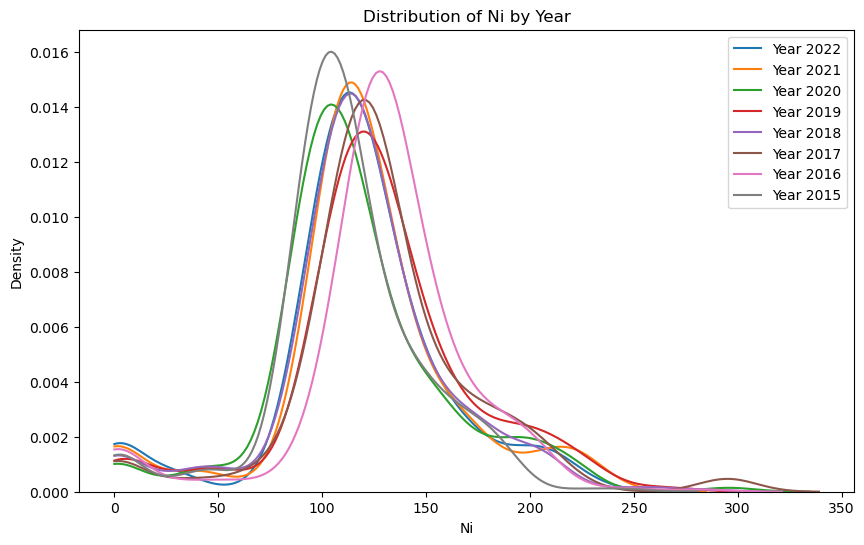

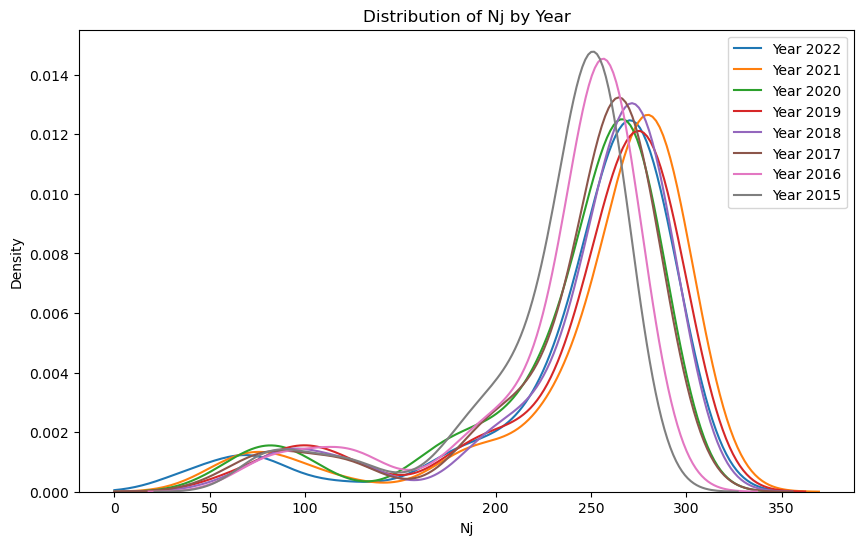

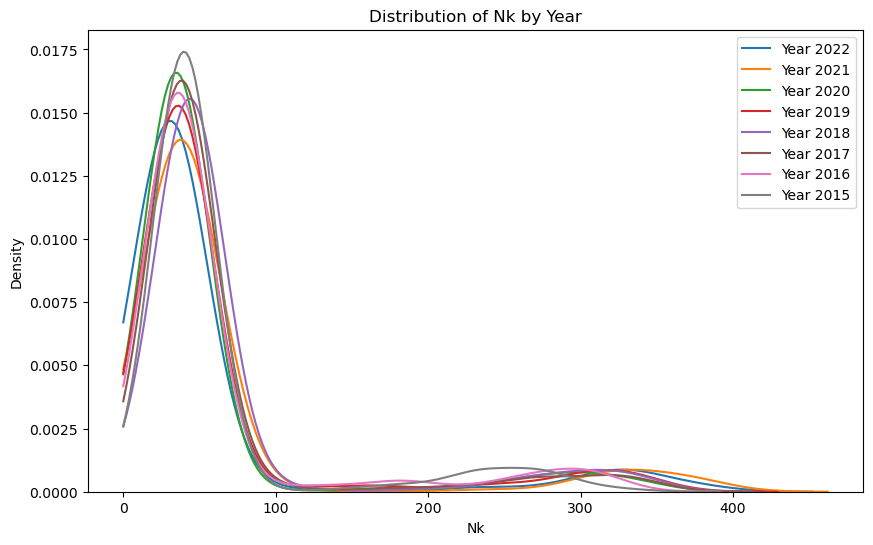

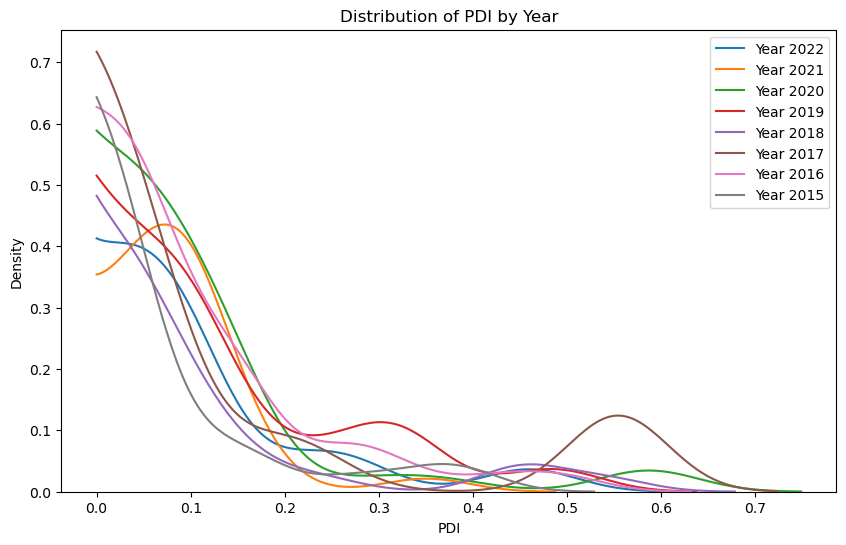

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
cd_df = pd.read_csv(filepath+'newcd_data.csv',low_memory=False)
trend_df = cd_df[(cd_df['year']>2014)&(cd_df['year']<2023)]
# 假设 cd_df 是你的数据集
# 绘制不同年份的 d_index 分布图
name_dic = {'ni13.9_1':'Ni',
            'nj13.9_1':'Nj',
            'nk13.9_1':'Nk',
            'cd13.9_1':'PDI',
            }
#col_name = 'nj13.9_1'#'cd13.9_1'
for col_name in name_dic.keys():
    plt.figure(figsize=(10, 6))
    for year in trend_df['year'].unique():
        #sns.kdeplot(trend_df[trend_df['year'] == year][col_name], label=f'Year {year}')
        sns.kdeplot(
        trend_df[trend_df['year'] == year][col_name], 
        label=f'Year {year}', 
        clip=(0, None)
        )
        '''
        plt.hist(
            trend_df[trend_df['year'] == year][col_name], 
            bins=30, 
            density=True, 
            alpha=0.5, 
            label=f'Year {year}'
        )
        '''
    plt.title('Distribution of '+name_dic[col_name]+' by Year')
    plt.xlabel(name_dic[col_name])
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(filepath+f'distribution_{name_dic[col_name]}.svg')

'''
# Kolmogorov-Smirnov 检验
years = trend_df['year'].unique()
ks_results = {}
for i in range(len(years) - 1):
    ks_stat, p_value = ks_2samp(trend_df[trend_df['year'] == years[i]][col_name],
                                trend_df[trend_df['year'] == years[i + 1]][col_name])
    ks_results[f'{years[i]} vs {years[i + 1]}'] = (ks_stat, p_value)

# 输出 Kolmogorov-Smirnov 检验结果
for comparison, (ks_stat, p_value) in ks_results.items():
    print(f'{comparison} - KS Statistic: {ks_stat}, p-value: {p_value}')
'''

In [369]:
cd_df.columns

Index(['level_0', 'index', 'productname', 'year', 'cd13.9_1', 'ni13.9_1',
       'nj13.9_1', 'nk13.9_1', 'nnan13.9_1', 'cd13.9_1_cartype',
       'ni13.9_1_cartype', 'nj13.9_1_cartype', 'nk13.9_1_cartype',
       'nnan13.9_1_cartype', 'cd13.9_2', 'ni13.9_2', 'nj13.9_2', 'nk13.9_2',
       'nnan13.9_2', 'cd13.9_2_cartype', 'ni13.9_2_cartype',
       'nj13.9_2_cartype', 'nk13.9_2_cartype', 'nnan13.9_2_cartype',
       'genecount', 'newgenecount', 'newgenecountrate', 'cd13.1_1', 'ni13.1_1',
       'nj13.1_1', 'nk13.1_1', 'nnan13.1_1', 'cd13.1_1_cartype',
       'ni13.1_1_cartype', 'nj13.1_1_cartype', 'nk13.1_1_cartype',
       'nnan13.1_1_cartype', 'cd13.1_2', 'ni13.1_2', 'nj13.1_2', 'nk13.1_2',
       'nnan13.1_2', 'cd13.1_2_cartype', 'ni13.1_2_cartype',
       'nj13.1_2_cartype', 'nk13.1_2_cartype', 'nnan13.1_2_cartype',
       'cd13.8_1', 'ni13.8_1', 'nj13.8_1', 'nk13.8_1', 'nnan13.8_1',
       'cd13.8_1_cartype', 'ni13.8_1_cartype', 'nj13.8_1_cartype',
       'nk13.8_1_cartype', 'nnan

In [404]:
len(node_df[(node_df['cartype']=='fuel')&(node_df['year']==2023)])/len(node_df[(node_df['year']==2023)])
#len(node_df[(node_df['cartype']=='electric')&(node_df['year']==2023)])/len(node_df[(node_df['year']==2023)])
#node_df['cartype'].unique()

0.6634615384615384

In [401]:
node_df['cartype']

0         fuel
20      hybrid
22        fuel
23      hybrid
24      hybrid
         ...  
4265      fuel
4264      fuel
4263      fuel
4268      fuel
4262    hybrid
Name: cartype, Length: 4496, dtype: object

In [324]:
file_path = r"C:/Users/heyouwei/code/car/20230415/2013_2024_period/tfidf_panel_data.csv"
data = pd.read_csv(file_path)

# 确保 'year' 和 'cd13.9_1' 列存在
if 'year' in data.columns and 'cd13.9_1' in data.columns:
    # 计算每年的 'cd13.9_1' 平均值
    year_avg = data.groupby('year')['cd13.9_1'].transform('mean')

    # 创建 'd_dummy' 列
    data['d_dummy'] = data['cd13.9_1'] > year_avg
    data['d_dummy'] = data['d_dummy'].replace({True: 1, False: 0})

    # 保存处理后的数据
    output_path = r"C:/Users/heyouwei/code/car/20230415/2013_2024_period/tfidf_panel_data_with_d_dummy.csv"
    data.to_csv(output_path, index=False)

    print(f"处理完成，保存到: {output_path}")
else:
    print("Required columns 'year' and 'cd13.9_1' not found in the data.")

处理完成，保存到: C:/Users/heyouwei/code/car/20230415/2013_2024_period/tfidf_panel_data_with_d_dummy.csv


In [325]:
file_path = r"C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_panel_data.csv"
data = pd.read_csv(file_path)

# 确保 'year' 和 'cd13.9_1' 列存在
if 'year' in data.columns and 'cd13.9_1' in data.columns:
    # 计算每年的 'cd13.9_1' 平均值
    year_avg = data.groupby('year')['cd13.9_1'].transform('mean')

    # 创建 'd_dummy' 列
    data['d_dummy'] = data['cd13.9_1'] > year_avg
    data['d_dummy'] = data['d_dummy'].replace({True: 1, False: 0})

    # 保存处理后的数据
    output_path = r"C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_panel_data_with_d_dummy.csv"
    data.to_csv(output_path, index=False)

    print(f"处理完成，保存到: {output_path}")
else:
    print("Required columns 'year' and 'cd13.9_1' not found in the data.")

处理完成，保存到: C:/Users/heyouwei/code/car/20230415/2013_2024_period/tf_panel_data_with_d_dummy.csv


In [323]:
data[data['d_dummy']<0]

,Unnamed: 0,avg_wdis_rate,avg_dis_rate,avg_winh_rate,avg_inh_rate,avg_dis_rate_diff,avg_inh_rate_diff,avg_wnew_rate,avg_new_rate,avg_new_rate_diff,...,vfm,rate,newgenecountrate,avg_anc_cd13.9_1,brand,year,cartype,series,cd13.9_1,d_dummy
0,0,0.172972,0.381070,0.771795,0.591922,-0.208098,0.179873,0.228205,0.408078,-0.179873,...,5.0,5.0,0.000000,-0.280333,lotus,2024,fuel,emira,NaN,-1
1,1,0.148987,0.494491,0.706892,0.459177,-0.345504,0.247715,0.293108,0.540823,-0.247715,...,3.0,4.0,0.000000,-0.036400,bmw,2024,hybrid,x5,NaN,-1
2,2,0.069308,0.222514,0.820469,0.720138,-0.153206,0.100330,0.179531,0.279862,-0.100330,...,5.0,4.7,0.000000,-0.120333,bmw,2024,fuel,m3,NaN,-1
3,3,0.054237,0.132954,0.952601,0.865606,-0.078717,0.086995,0.047399,0.134394,-0.086995,...,5.0,5.0,0.000000,-0.377700,alfa,2024,hybrid,romeo tonale,NaN,-1
4,4,0.196632,0.641153,0.611111,0.303803,-0.444521,0.307308,0.388889,0.696197,-0.307308,...,5.0,5.0,0.000000,-0.202933,bmw,2024,hybrid,m440 gran coupe,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4148,4148,0.259704,0.789016,0.377072,0.159135,-0.529312,0.217937,0.622928,0.840865,-0.217937,...,NaN,NaN,0.150838,NaN,ford,2014,fuel,fusion,-0.7579,-1
4149,4149,0.214602,0.718322,0.407216,0.217262,-0.503721,0.189954,0.592784,0.782738,-0.189954,...,NaN,NaN,0.108280,NaN,audi,2014,fuel,a7,-0.7474,-1
4150,4150,0.253269,0.755959,0.349392,0.175098,-0.502690,0.174294,0.650608,0.824902,-0.174294,...,NaN,NaN,0.106742,NaN,volvo,2014,fuel,s60,-0.7500,-1
4151,4151,0.263187,0.757341,0.354237,0.189797,-0.494154,0.164440,0.645763,0.810203,-0.164440,...,NaN,NaN,0.082418,NaN,ferrari,2014,hybrid,la,-0.7553,-1


In [287]:
regdata = pd.read_csv(filepath+'product_regdata.csv')


In [294]:
regdata[(regdata['year']>=2014)&(regdata['brand']=='tesla')]['cd13.9_1'].max()#chevrolet

0.4237